In [1]:
# consider filtered sla to various scales 
import numpy as np
import xarray as xr
import gsw
import time 
from datetime import datetime
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy
import cartopy.crs as ccrs 
import cmocean
from scipy.interpolate import interp1d 
import scipy.ndimage as si
from scipy.fftpack import fft
from tqdm.notebook import tqdm
import pickle 
from altimetry_tools import Filter, smooth_tracks, specsharp
from altimetry_tools import smooth_tracks_deg, smooth_tracks_Ld
import warnings 
warnings.filterwarnings('ignore')

# load coastlines
# x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/coastlines_global.nc') 
x3 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/coastlines_global.nc') 
x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/landmask2.nc') 
land_cmap = plt.cm.get_cmap('viridis')
land_cmap.set_over('#D3D3D3') #FFDEAD
land_cmap.set_under('w')

In [2]:
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + 'processed_vel_x20.p', 'rb'))
load_sat.keys()

dict_keys(['dist', 'vel', 'lon_record', 'lat_record', 'track', 'grid_spacing', 'time'])

In [3]:
# load level1 processed data (filtering in this notebook) 
dist = load_sat['dist']
vel = load_sat['vel']
# sla = load_sat['sla']
lon_record = load_sat['lon_record']
lat_record = load_sat['lat_record']
track_record = load_sat['track']
time_record = load_sat['time']

In [4]:
hor_grid_spacing = dist[0][1] - dist[0][0]
dx = hor_grid_spacing
L = 275                                          # = number of grid points contributing to each spectral estimate
k = np.linspace(0, 1.0/(2.0*dx), np.int(L/2))
# inn = [7,9,11,13,15,17,19,21,27,34,39]  * THIS IS BEST FOR COARSE USE

# ***
# wavelengths = np.flip(np.concatenate((np.arange(60,310,10), np.array([400]))))
wavelengths = np.flip(np.arange(dx*3,300+dx,dx))
# *** 
k_sub = 1/wavelengths
coarsening_factors = np.nan * np.ones(len(k_sub))
filter_width = np.nan * np.ones(len(k_sub))
for i in range(len(k_sub)):
    thisone =  np.round((1/k_sub[i])/hor_grid_spacing)
    print('smoothing to ' + str(thisone*hor_grid_spacing) + ' km')
    coarsening_factors[i] = thisone
    filter_width[i] = thisone*hor_grid_spacing
coarse_fac = coarsening_factors*hor_grid_spacing
print('filtering factors = ' + str(coarsening_factors) + ' ** = full width of boxcar **')
filter_band = filter_width[0:-1] + np.diff(filter_width)/2
filter_band = np.append(filter_band, (filter_width[-1] - hor_grid_spacing)/2 + hor_grid_spacing)
band_centers = filter_band
band_ends = filter_width
print('filter band centers: ' + str(filter_band))
print('filter band ends: ' + str(band_ends))

smoothing to 300.0 km
smoothing to 280.0 km
smoothing to 260.0 km
smoothing to 240.0 km
smoothing to 220.0 km
smoothing to 200.0 km
smoothing to 180.0 km
smoothing to 160.0 km
smoothing to 140.0 km
smoothing to 120.0 km
smoothing to 100.0 km
smoothing to 80.0 km
smoothing to 60.0 km
filtering factors = [15. 14. 13. 12. 11. 10.  9.  8.  7.  6.  5.  4.  3.] ** = full width of boxcar **
filter band centers: [290. 270. 250. 230. 210. 190. 170. 150. 130. 110.  90.  70.  40.]
filter band ends: [300. 280. 260. 240. 220. 200. 180. 160. 140. 120. 100.  80.  60.]


In [5]:
# prep for partitioning into months 
year_day = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # days per month 
# year_day = np.arange(0,365,14)  # bi-weekly intervals  
year_time_record = []
for i in range(len(time_record)):
    t_s = datetime.utcfromtimestamp(time_record[i][0])  # start time 
    offset_i = np.sum(year_day[0:t_s.month - 1])/365 + t_s.day/365 + t_s.hour/(365*24)  # starting time index (fractional days)
    year_time_record.append(((time_record[i] - time_record[i][0])/(60*60*24))/365 + offset_i)

In [6]:
# SET FILTERING PARAMETERS 
dx = 1
LfB = coarsening_factors.copy()  # boxcar
LfT = LfB  # /2                  # taper
LfG = LfB  # /np.sqrt(6)         # gaussian 

In [7]:
# if playing with SLA 
# SQUARE THE SLA 
# sla_sq = []
# for i in tqdm(range(len(sla))):
#     sla_sq.append(sla[i]**2)
    
# sla_smooth_dict = []
# sla_sq_smooth_dict = []
# # remember, coarsening factors ordered large scale to small scale 
# for i in tqdm(range(len(coarsening_factors))):
#     sla_filt_i = Filter(N, 'Taper', sla, dx, LfT[i], plot_filter=1)
#     sla_smooth_dict.append(sla_filt_i)
#     # print((i+1)/len(coarsening_factors))

# SLA
# -- Gaussian filter 
# sla_G_dict = []
# for i in tqdm(range(len(coarsening_factors))):
#     sla_G_filt_i = Filter(N, 'Gaussian', sla, dx, LfG[i], plot_filter=0)  # if boxcar--> np.int(LfB[i])
#     sla_G_dict.append(sla_G_filt_i)

In [7]:
# -- SMOOTH & COARSEN VELOCITY (loop over desired coarsening factors)# 
# SQUARE THE VELOCITY 
vel_sq = []
for i in tqdm(range(len(vel))):
    vel_sq.append(vel[i]**2)
vel_smooth_dict = []
vel_sq_smooth_dict = []
# remember, coarsening factors ordered large scale to small scale 
for i in tqdm(range(len(coarsening_factors))):  
    vel_filt_i = Filter('Taper', vel, dx, LfT[i], plot_filter=0)
    vel_sq_filt_i = Filter('Taper', vel_sq, dx, LfT[i], plot_filter=0)
    vel_smooth_dict.append(vel_filt_i)
    vel_sq_smooth_dict.append(vel_sq_filt_i)

Using default N, N = 68 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 68 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 63 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 63 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 59 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 59 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 54 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 54 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 50 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 50 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 45 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 45 If d>2 or X is not pi then results might not be accurate.
Using default N,

In [9]:
# -- Gaussian filter 
vel_G_dict = []
vel_sq_G_dict = []
for i in tqdm(range(len(coarsening_factors))):
    vel_G_filt_i = Filter('Gaussian', vel, dx, LfG[i], plot_filter=0)  
    vel_sq_G_filt_i = Filter('Gaussian', vel_sq, dx, LfT[i], plot_filter=0)
    vel_G_dict.append(vel_G_filt_i)
    vel_sq_G_dict.append(vel_sq_G_filt_i)

Using default N, N = 20 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 20 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 19 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 19 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 17 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 17 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 16 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 16 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 15 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 15 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 13 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 13 If d>2 or X is not pi then results might not be accurate.
Using default N,

In [170]:
# -- boxcar filter
# vel_b_dict = []
# for i in range(len(coarsening_factors)):
#     vel_b_filt_i = Filter('boxcar', vel, dx, np.int(LfB[i]), plot_filter=0)  # if boxcar--> np.int(LfB[i])
#     vel_b_dict.append(vel_b_filt_i)

In [10]:
# if desired filter to Ld1
# Chelton et al. 1998 'global variability of the first baroclinic rossby radius of deformation'
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc')  
c98 = c98['values'].data
vel_filtered_Ld = smooth_tracks_Ld(dist, vel, lon_record, lat_record, hor_grid_spacing, c98)
vel_sq_filtered_Ld = smooth_tracks_Ld(dist, vel_sq, lon_record, lat_record, hor_grid_spacing, c98)

In [8]:
# NEED TO RUN THIS CELL 
# sla variable is really the velocity (raw and filtered)...the name sla is arbitrary lol
# sla = sla  
# sla_s_dict = sla_smooth_dict      
sla = vel
sla_s_dict = vel_smooth_dict          # SHARP
# sla_G_dict = vel_G_dict             # Gaussian
# sla_s_dict = vel_b_dict             # BOXCAR
# sla_Ld_dict = vel_filtered_Ld         # Ld1 

sla_sq_s_dict = vel_sq_smooth_dict    # SHARP SQ
# sla_sq_G_dict = vel_sq_G_dict         # Gaussian SQ
# sla_sq_Ld_dict = vel_sq_filtered_Ld   # SHARP SQ
# (**increasing indices big to small scales**)

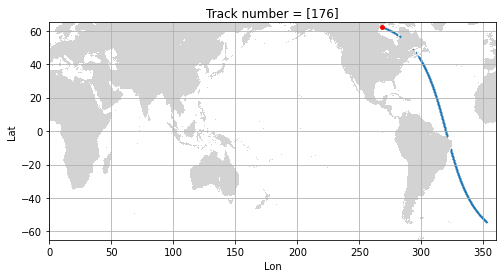

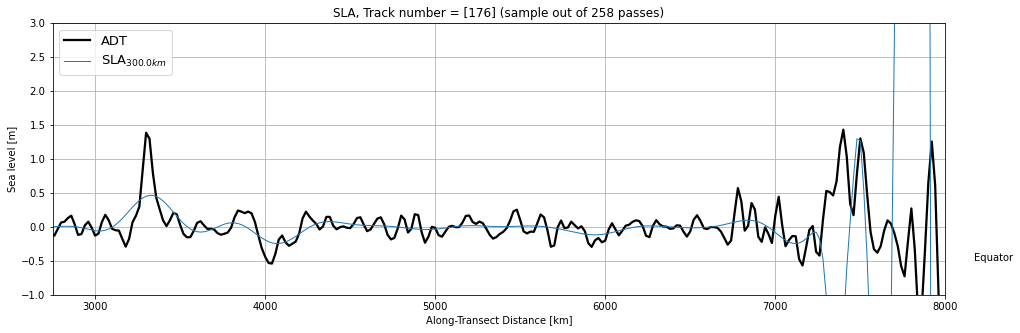

In [9]:
# -- choose a track (to show SLA, Vel, Track Location) (SAMPLE PLOT)
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65
t_i = np.array([176])  # s3a 33 en 3 # J2 24, 176 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 6
save_f = 0
good_indi_dist = np.where(track_record == t_i)[0][0]

f, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.pcolor(x4['lon'].values, x4['lat'].values, x4['landMask'].values, vmin=0.2, vmax=0.3, cmap=land_cmap)
ax.scatter(lon_record[good_indi_dist], lat_record[good_indi_dist], s=0.25)
ax.scatter(lon_record[good_indi_dist][0], lat_record[good_indi_dist][0], s=15, color='r')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title('Track number = ' + str(t_i))
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sla_track_loc', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (16, 5))
# for i in range(np.shape(sla[good_indi_dist])[0]):
#     ax.plot(dist[good_indi_dist], sla[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
    
eq_region = np.where(np.abs(lat_record[good_indi_dist]) < 0.1)[0]
if len(eq_region) > 0:
    ax.plot([dist[good_indi_dist][eq_region], dist[good_indi_dist][eq_region]], [-2, 2], color='k', linestyle='--')
    ax.text(dist[good_indi_dist][eq_region][0] + 30, -0.5, 'Equator')
    
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], sla[good_indi_dist][i, :], linewidth=2.25, label=r'ADT', color='k')
    for j in [0]:  # [0, np.int(np.round(len(coarsening_factors)/4)), -10, -4]:  # range(len(sla_s_dict)):
        ax.plot(dist[good_indi_dist], sla_s_dict[j][good_indi_dist][i, :], \
                linewidth=1, label=r'SLA$_{' + str(coarse_fac[j]) + 'km}$')
        # ax.plot(dist[good_indi_dist], sla_G_dict[j][good_indi_dist][i, :], \
        #         linewidth=1, label=r'SLA$_{' + str(coarse_fac[j]) + 'km}$', color='g')

ax.set_xlim([2750, 8000])
ax.set_ylim([-1, 3])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Sea level [m]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=13)
ax.set_title('SLA, Track number = ' + str(t_i) + ' (sample out of ' + str(np.shape(sla[good_indi_dist])[0]) + ' passes)')
ax.grid()
plt.show()
# if save_f:
# f.savefig(this_sat + '_sla_sample_track', dpi=300)

In [10]:
lon_w = 0
lon_e = 360
lat_s = -70
lat_n = 70

# lat/lon key
for i in range(len(lon_record)):
    if i < 1:
        lon_t = lon_record[i]
        lat_t = lat_record[i]
        track_t = np.ones(len(lon_record[i])) * track_record[i]
    else:
        lon_t = np.concatenate((lon_t, lon_record[i]))
        lat_t = np.concatenate((lat_t, lat_record[i]))    
        track_t = np.concatenate((track_t, np.ones(len(lon_record[i])) * track_record[i]))

In [11]:
# statistics from un-filtered data (set binning parameters)
step = 1
lon_win = 4 # 2.5
lat_win = 4 # 2.5
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 25
mean_sla_total = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]     
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2
        
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                            (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                            (np.abs(lat_record[ai[tib]]) > 5))[0]
            if count < 1:
                sla_total_i = sla[ai[tib]][:, inn2].flatten()
                count = count + 1
            else:
                sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
        if (len(ai) > 1):
            if (len(sla_total_i) > thresh):
                mean_sla_total[i, j] = np.nanmean(sla_total_i**2)              # non-seasonal
        ai = 0

In [12]:
# ---> ALONG-TRACK ---> 2d MAP (variance at each scale as a function of time) 
# twelve increments (months)
months = np.concatenate((np.array([0]), (np.cumsum(np.array([year_day])))))/365
s_i = np.concatenate((months[0:-1][:, None], months[1:][:, None]), axis=1) 
# initialize arrays  
mean_sla0 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_check = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_Ld = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_sla_smoothG = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_sla_smoothB = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_sla_sq_smooth3 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
mean_diff0 = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_diff0G = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
mean_diff0Ld = np.nan * np.ones((len(s_i), len(lon_bin_c), len(lat_bin_c)))
# -- master loop 
for tt in range(len(s_i)):                        # month 
    for i in tqdm(range(1, len(lon_bin_c) - 1)):  # lon
        for j in range(1, len(lat_bin_c) - 1):    # lat      
            this_lon = lon_bin_c[i]
            this_lat = lat_bin_c[j]     
            this_lon0 = this_lon - lon_win/2
            this_lon1 = this_lon + lon_win/2
            this_lat0 = this_lat - lat_win/2
            this_lat1 = this_lat + lat_win/2      
            inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
            # tracks that fall within this box 
            [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
            countf = 0
            filters = {}
            filtersG = {}
            filtersB = {}
            filters_sq = {}
            filtersG_sq = {}
            for tib in range(len(ai)):
                # for each track that crosses through box, again find subset of grid points in box 
                inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                                (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                                (np.abs(lat_record[ai[tib]]) > 5))[0]
                # time bin 
                this_time = np.mod(year_time_record[ai[tib]], 1)
                time_in = np.where((this_time > s_i[tt, 0]) & (this_time < s_i[tt, 1]))[0]
                
                # loop over each filter scale (ORDER large to small)   
                if countf < 1:
                    sla_i = sla[ai[tib]][time_in][:, inn2].flatten()                         # raw
                    sla_total_i = sla[ai[tib]][:, inn2].flatten()
                    # sla_smooth_check = sla_s_dict[10][ai[tib]][time_in][:, inn2].flatten() 
                    # sla_Ld_i = sla_Ld_dict[ai[tib]][time_in][:, inn2].flatten()
                    for ff in range(len(coarsening_factors)):  
                        filters[coarsening_factors[ff]] = sla_s_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        # filtersG[coarsening_factors[ff]] = sla_G_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        # filtersB[coarsening_factors[ff]] = vel_b_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        filters_sq[coarsening_factors[ff]] = sla_sq_s_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                        # filtersG_sq[coarsening_factors[ff]] = sla_sq_G_dict[ff][ai[tib]][time_in][:, inn2].flatten()
                    countf = countf + 1
                else:
                    sla_i = np.append(sla_i, sla[ai[tib]][time_in][:, inn2].flatten())
                    sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
                    # sla_smooth_check = np.append(sla_smooth_check, sla_s_dict[10][ai[tib]][time_in][:, inn2].flatten())
                    # sla_Ld_i = np.append(sla_Ld_i, sla_Ld_dict[ai[tib]][time_in][:, inn2].flatten())
                    for ff in range(len(coarsening_factors)):  # range(len(coarsening_factors)-1, -1, -1):
                        filters[coarsening_factors[ff]] = np.concatenate((filters[coarsening_factors[ff]], sla_s_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        # filtersG[coarsening_factors[ff]] = np.concatenate((filtersG[coarsening_factors[ff]], sla_G_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        # filtersB[coarsening_factors[ff]] = np.concatenate((filtersB[coarsening_factors[ff]], vel_b_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        filters_sq[coarsening_factors[ff]] = np.concatenate((filters_sq[coarsening_factors[ff]], sla_sq_s_dict[ff][ai[tib]][time_in][:, inn2].flatten()))
                        # filtersG_sq[coarsening_factors[ff]] = np.concatenate((filtersG_sq[coarsening_factors[ff]], sla_sq_G_dict[ff][ai[tib]][time_in][:, inn2].flatten()))            
            
            # average in this lat/lon box 
            if countf > 0:  # (len(ai) > 1):
                if (len(sla_i) > thresh):
                    # -- unfiltered eddy energy estimate (highest resolution)
                    mean_sla0[tt, i, j] = np.nanmean(sla_i**2)  
                    #mean_sla_check[tt,i,j] = np.nanmean(sla_smooth_check**2)                
                    # mean_sla_Ld[tt,i,j] = np.nanmean(sla_Ld_i**2)
                    # mean_diff0Ld[tt,i,j] = np.nanmean(sla_i**2 - sla_Ld_i**2)
                    
                    # ORDER = large to small 
                    for cf in range(len(coarsening_factors)):
                        # -- large scale (\overline{\eta}^2) (filtering of the quantity, then squaring)
                        mean_sla_smooth[tt,i,j,cf] = np.nanmean(filters[coarsening_factors[cf]]**2)
                        # mean_sla_smoothG[tt,i,j,cf] = np.nanmean(filtersG[coarsening_factors[cf]]**2)
                        # mean_sla_smoothB[tt,i,j,cf] = np.nanmean(filtersB[coarsening_factors[cf]]**2)
                        # -- EKE w/o filtering the squared velocity 
                        # mean_diff0[tt,i,j,cf] = np.nanmean(sla_i**2 - filters[coarsening_factors[cf]]**2) 
                        # mean_diff0G[tt,i,j,cf] = np.nanmean(sla_i**2 - filtersG[coarsening_factors[cf]]**2)
                        # -- EKE w filtering the squared velocity 
                        mean_diff0[tt,i,j,cf] = np.nanmean(filters_sq[coarsening_factors[cf]] - filters[coarsening_factors[cf]]**2) 
                        # mean_diff0G[tt,i,j,cf] = np.nanmean(filtersG_sq[coarsening_factors[cf]] - filtersG[coarsening_factors[cf]]**2)
                    
            ai = 0

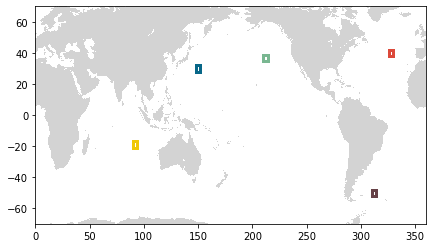

In [13]:
# pick locations and look at a time series of EKE 
frac_year = np.nan*np.ones(len(s_i))
for i in range(len(s_i)):
    frac_year[i] = np.nanmean(s_i[i])
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
# colors = ['#191970', '#DAA520', '#808000', '#8B0000', 'c', 'm']
colors = ['#79B791', '#086788', '#F0C808', '#DC493A', '#664147', 'm']
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -52, -48], [290, 294, 30, 34]])
# alternate set of locations to play with 
# order = ['Eastern Eq. Pac.', 'N. N. Pacific', 'S. E. Pac', 'N. Atl.', 'ACC2', 'Gulf Stream']
# location = np.array([[210, 214, 16, 20], [196, 200, 46, 50], [250, 254, -21, -17], \
#                      [310, 314, 42, 46], [98, 102, -52, -48], [290, 294, 30, 34]])

f, ax = plt.subplots(1,1, figsize = (7,4))
# ax.scatter(x4['lon'].values, x4['lat'].values, color='k', zorder=1, s=0.25)
ax.pcolor(x4['lon'].values, x4['lat'].values, x4['landMask'].values, vmin=0.2, vmax=0.3, cmap=land_cmap)
for i in range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax.plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=3)
    ax.plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=3)
    ax.plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    ax.plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=3)
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
plt.show()

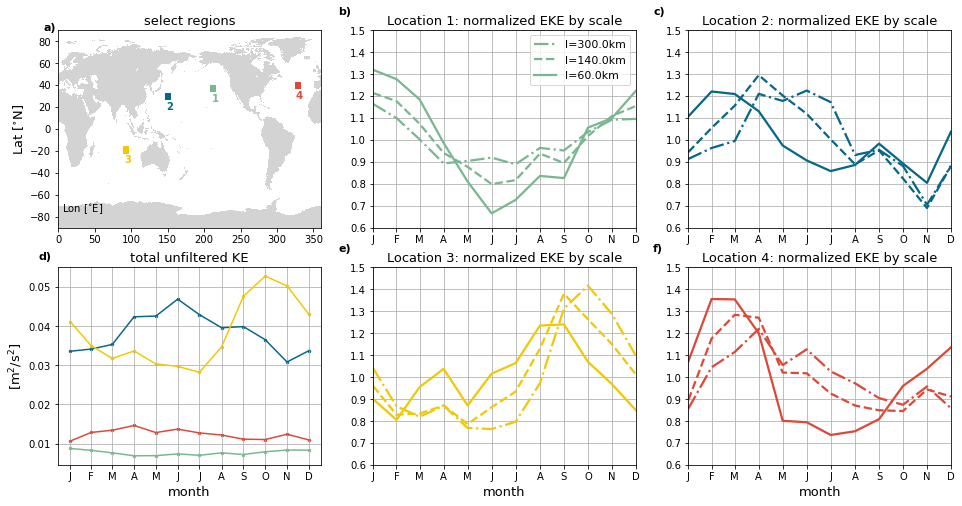

In [115]:
# seasonality in EKE 
f, ax = plt.subplots(2, 3, figsize = (16, 8))
ax[0,0].pcolor(x4['lon'].values, x4['lat'].values, x4['landMask'].values, vmin=0.2, vmax=0.3, cmap=land_cmap)
in_lon = []
in_lat = []
for i in [0,1,2,3]:  # range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax[0,0].plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    if i < 4:
        ax[0,0].text(this_lon0, this_lat0 - 10, str(i + 1), fontsize=10, color=colors[i], fontweight='bold')
    in_lon.append(np.where((lon_bin_c > this_lon0) & (lon_bin_c < this_lon1))[0])
    in_lat.append(np.where((lat_bin_c > this_lat0) & (lat_bin_c < this_lat1))[0])

ax[0,0].set_xlim([lon_w, lon_e])
ax[0,0].set_ylim([lat_s - 20, lat_n + 20])
# ax[0,0].set_xlabel('Lon', fontsize=13, horizontalalignment='left', x=0.0)
ax[0,0].text(5, -75, 'Lon [$^{\circ}$E]', fontsize=10)
ax[0,0].set_ylabel('Lat [$^{\circ}$N]', fontsize=13)
ax[0,0].set_title('select regions', fontsize=13)
ax[0,0].grid()

for i in [0,1,2,3]:  # range(5):
    ax[1,0].plot(frac_year, np.nanmean(mean_sla0[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], label=order[i])  # np.nanmean(np.nanmean(np.nanmean(mean_sla0[:, in1_lon][:, :, in1_lat], axis=1), axis=1))
    ax[1,0].scatter(frac_year, np.nanmean(mean_sla0[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], s=6)
    # std of total ke at each site 
    if (i == 1):  #  | (i == 2):
        for j in range(len(frac_year)):
            site_mean = np.nanmean(mean_sla0[j][in_lon[i], :][:, in_lat[i]])
            # ax[1,0].plot([frac_year[j]+(i*0.005), frac_year[j]+(i*0.005)], \
            #              [site_mean - np.nanstd(mean_sla0[j][in_lon[i], :][:, in_lat[i]]), \
            #               site_mean + np.nanstd(mean_sla0[j][in_lon[i], :][:, in_lat[i]])], color=colors[i])
ax[1,0].set_ylabel('[m$^2$/s$^2$]', fontsize=13)
ax[1,0].set_title('total unfiltered KE', fontsize=13)

# loop over each site, plot time series for three filtering scales 
to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15))[0]
# np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]])
# np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]])
# np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]])
axi=[[0,1], [0,2], [1,1], [1,2]]
for i in range(4):
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[0]]*hor_grid_spacing) + 'km', linestyle='-.', linewidth=2.25)
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[1]]*hor_grid_spacing) + 'km', linestyle='--', linewidth=2.25)
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
                 color=colors[i], label='l=' + str(coarsening_factors[to_show[2]]*hor_grid_spacing) + 'km', linewidth=2.25)

ax[0,1].set_title('Location 1: normalized EKE by scale', fontsize=13)
ax[0,2].set_title('Location 2: normalized EKE by scale', fontsize=13)
ax[1,1].set_title('Location 3: normalized EKE by scale', fontsize=13)
ax[1,2].set_title('Location 4: normalized EKE by scale', fontsize=13)
ax[0,1].set_xticks(frac_year)
ax[0,1].set_xticklabels(month_labels)
ax[0,2].set_xticks(frac_year)
ax[0,2].set_xticklabels(month_labels)
ax[1,0].set_xticks(frac_year)
ax[1,0].set_xticklabels(month_labels)
ax[1,0].set_xlabel('month', fontsize=13)
ax[1,1].set_xticks(frac_year)
ax[1,1].set_xticklabels(month_labels)
ax[1,1].set_xlabel('month', fontsize=13)
ax[1,2].set_xticks(frac_year)
ax[1,2].set_xticklabels(month_labels)
ax[1,2].set_xlabel('month', fontsize=13)
handles, labels = ax[0,1].get_legend_handles_labels()
ax[0,1].legend(handles, labels, fontsize=11)
ax[0,1].set_xlim([frac_year[0], frac_year[-1]])
ax[0,2].set_xlim([frac_year[0], frac_year[-1]])
ax[1,1].set_xlim([frac_year[0], frac_year[-1]])
ax[1,2].set_xlim([frac_year[0], frac_year[-1]])
ax[0,1].set_ylim([0.6, 1.5])
ax[0,2].set_ylim([0.6, 1.5])
ax[1,1].set_ylim([0.6, 1.5])
ax[1,2].set_ylim([0.6, 1.5])
ax[0,0].text(-20, 90, 'a)', fontweight='bold', fontsize=11)
ax[0,1].text(-0.08, 1.57, 'b)', fontweight='bold', fontsize=11)
ax[0,2].text(-0.08, 1.57, 'c)', fontweight='bold', fontsize=11)
ax[1,0].text(-0.08, 0.057, 'd)', fontweight='bold', fontsize=11)
ax[1,1].text(-0.08, 1.57, 'e)', fontweight='bold', fontsize=11)
ax[1,2].text(-0.08, 1.57, 'f)', fontweight='bold', fontsize=11)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_eke2_by_month.jpg', dpi=500)

In [14]:
loc_points = np.concatenate((np.array([np.nanmean(location[0, 2:]), np.nanmean(location[0, 0:2])])[None, :], \
                             np.array([np.nanmean(location[1, 2:]), np.nanmean(location[1, 0:2])])[None, :], \
                             np.array([np.nanmean(location[2, 2:]), np.nanmean(location[2, 0:2])])[None, :], \
                             np.array([np.nanmean(location[3, 2:]), np.nanmean(location[3, 0:2])])[None, :], \
                             np.array([np.nanmean(location[4, 2:]), np.nanmean(location[4, 0:2])])[None, :], \
                             np.array([np.nanmean(location[5, 2:]), np.nanmean(location[5, 0:2])])[None, :]), axis=0)
labely = order
loc_points = loc_points
labely = labely

In [18]:
monte_carlo = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/j2_monte_carlo_error_l3.p', 'rb'))

Using default N, N = 32 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 10 If d>2 or X is not pi then results might not be accurate.


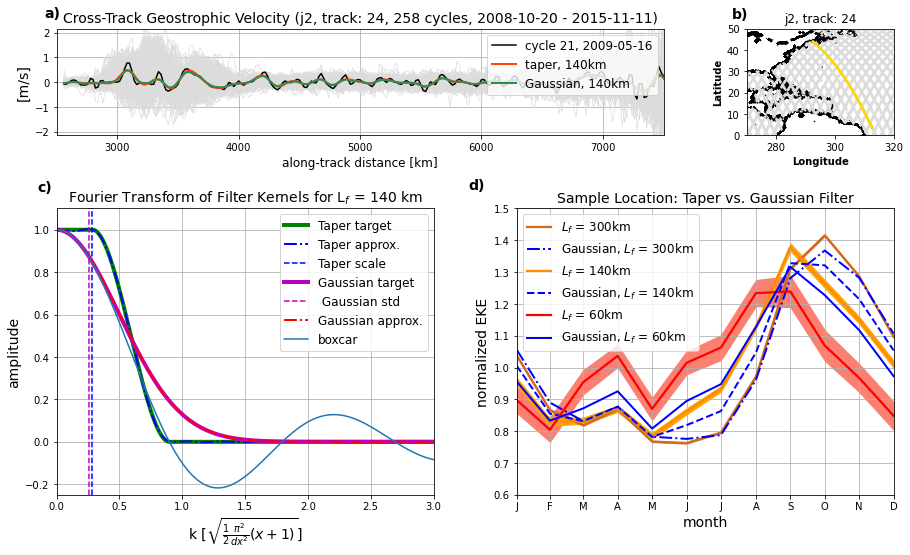

In [46]:
# compare three filters at one location 
i = 2
ls0 = ['-.', '--', '-']

# &&& sample filter kernel
from altimetry_tools import filterSpec1

f = plt.figure(figsize=(13,8))  # , constrained_layout=True)
gs = GridSpec(3, 4, figure=f)
ax0 = f.add_subplot(gs[0, 0:3])
a = f.add_subplot(gs[0, 3])
ax1 = f.add_subplot(gs[1:, 0:2])
ax2 = f.add_subplot(gs[1:, 2:])

pi = 21
t_i = np.array([24]) 
gid = np.where(track_record == t_i)[0][0]
for i in range(np.shape(vel[gid])[0]):
    ax0.plot(dist[gid], vel[gid][i, :], color='#DCDCDC', linewidth=0.75)                                         # all vel
ax0.plot(dist[gid], vel[gid][pi, :], color='k', linewidth=1.5, \
         label='cycle ' + str(pi) + ', ' + str(datetime.utcfromtimestamp(time_record[gid][pi]))[0:10])                                        # raw 
# ax0.plot(dist[gid], vel_boxcar[gid][pi, :], label='boxcar, ' + str(np.int(sample_LfB*hor_grid_spacing)) + 'km', linewidth=2)                      # boxcar 
ax0.plot(dist[gid], vel_smooth_dict[8][gid][pi, :], label='taper, ' + \
         str(np.int(coarsening_factors[8]*hor_grid_spacing)) + 'km', color='#FF4500', linewidth=2)                 # sharp filter (lap/bi)
ax0.plot(dist[gid], vel_G_dict[8][gid][pi, :], label='Gaussian, ' + \
         str(np.int(coarsening_factors[8]*hor_grid_spacing)) + 'km', color='#2E8B57', linewidth=2)     # Gaussian 
ax0.set_title('Cross-Track Geostrophic Velocity (j2, track: ' + str(t_i[0]) + \
              ', ' + str(np.shape(vel[gid])[0]) + ' cycles, ' + \
              str(datetime.utcfromtimestamp(time_record[gid][0]))[0:10] + ' - ' + \
              str(datetime.utcfromtimestamp(time_record[gid][-1]))[0:10]+ ')', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=12, loc='upper right')
ax0.set_xlabel('along-track distance [km]', fontsize=12)
ax0.set_ylabel('[m/s]', fontsize=14)
ax0.set_xlim([2500, 7500])
ax0.set_ylim([-2.15, 2.15])
ax0.grid()

z_lon_w = 270
z_lon_e = 320
z_lat_s = 0
z_lat_n = 50
inn = np.where((lon_t > z_lon_w) & (lon_t < z_lon_e) & (lat_t > z_lat_s) & (lat_t < z_lat_n))[0]
# tracks that fall within this box 
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True) 
a.scatter(x3['lon'].values, x3['lat'].values, s=0.1, color='k')
for i in range(len(ai)):
    a.scatter(lon_record[ai[i]], lat_record[ai[i]], s=1, color='#DCDCDC')
subset_in = np.where((dist[gid] > 2500) & (dist[gid] < 7500))[0]
a.scatter(lon_record[gid][subset_in], lat_record[gid][subset_in], s=1, color='#FFD700')
a.set_xlim([z_lon_w, z_lon_e])
a.set_ylim([z_lat_s, z_lat_n])
a.set_xlabel('Longitude', fontsize=10, fontweight='bold')
a.set_ylabel('Latitude', fontsize=10, fontweight='bold')
a.set_title(str(this_sat) + ', track: ' + str(t_i[0]), fontsize=12, alpha=1)

# f, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
plt.sca(ax1)
ex_filt = 7
p,NL,sL,NB,sB = filterSpec1(1,ex_filt,d=1,shape="Taper",X=np.pi,N=-1,plot_filter=1)
pG,NL_G,sL_G,NB_G,sB_G = filterSpec1(1,ex_filt,d=1,shape="Gaussian",X=np.pi,N=-1,plot_filter=1)
ax1.set_xlabel(r'k [$\sqrt{\frac{1}{2}\frac{\pi^2}{dx^2}(x+1)}$]', fontsize=14)
ax1.set_ylabel('amplitude', fontsize=14)
ax1.set_title('Fourier Transform of Filter Kernels for L$_f$ = 140 km', fontsize=14)
d = 1
xx = np.linspace(-1,1,10000)
sMax = d*(np.pi/1)**2
k = np.sqrt((sMax/2)*(xx+1))
F_Boxcar = lambda p: np.sinc(p*(ex_filt)/(2*np.pi))
plt.plot(k, F_Boxcar(k), label='boxcar')
plt.legend(fontsize=12)
ax1.set_ylim([-.25, 1.1])
ax1.set_xlim([0, 3])
plt.tight_layout(pad=2)

i = 2
pre_m = np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/ \
                     np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]])
ax2.fill_between(frac_year, pre_m - np.nanstd(monte_carlo['80km'], axis=0), \
                pre_m + np.nanstd(monte_carlo['80km'], axis=0), color='#FA8072', zorder=0)
pre_m = np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/ \
                     np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]])
ax2.fill_between(frac_year, pre_m - np.nanstd(monte_carlo['140km'], axis=0), \
                pre_m + np.nanstd(monte_carlo['140km'], axis=0), color='#FFA500', zorder=0)
pre_m = np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/ \
                     np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]])
ax2.fill_between(frac_year, pre_m - np.nanstd(monte_carlo['300km'], axis=0), \
                pre_m + np.nanstd(monte_carlo['300km'], axis=0), color='#CD853F', zorder=0)

cc = ['#D2691E', '#FF8C00', 'r']  # ls0[j]
for j in range(3):
    ax2.plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[j]], axis=tuple(range(1, 3)))/ \
                     np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[j]]), \
                     color=cc[j], label='$L_f$ = ' + str(np.int(coarsening_factors[to_show[j]]*hor_grid_spacing)) + 'km', \
                     linestyle='-', linewidth=2.25)
    ax2.plot(frac_year, np.nanmean(mean_diff0G[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[j]], axis=tuple(range(1, 3)))/ \
                     np.nanmean(mean_diff0G[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[j]]), \
                     color='b', label='Gaussian, $L_f$ = ' + str(np.int(coarsening_factors[to_show[j]]*hor_grid_spacing)) + 'km', \
                     linestyle=ls0[j], linewidth=2)

ax2.set_xlim([frac_year[0], frac_year[-1]])
ax2.set_ylim([0.6, 1.5])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=12, loc='upper left')
ax2.set_xticks(frac_year)
ax2.set_xticklabels(month_labels)
ax2.set_xlabel('month', fontsize=14)
ax2.set_ylabel('normalized EKE', fontsize=14)
ax2.set_title('Sample Location: Taper vs. Gaussian Filter', fontsize=14)
ax2.grid()
ax0.text(2400, 2.6, 'a)', fontweight='bold', fontsize=14)
a.text(z_lon_w-5, z_lat_n+5, 'b)', fontweight='bold', fontsize=14)
ax1.text(-0.15, 1.18, 'c)', fontweight='bold', fontsize=14)
ax2.text(-0.075, 1.56, 'd)', fontweight='bold', fontsize=14)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_filter_comps_l3_w_track.jpg', dpi=450)

In [147]:
# frac ke in mesoscale band
summer = [.6, 0.85]
winter = [0.15, 0.4]
sum_in = np.where((s_i[:, 0] >= summer[0]) & (s_i[:, 0] <= summer[1]))[0]
win_in = np.where((s_i[:, 0] >= winter[0]) & (s_i[:, 0] <= winter[1]))[0]
meso_band0_i = np.where((coarsening_factors <= 7) & (coarsening_factors >= 4))[0] # was 80-160 km 
meso_band1_i = np.where((coarsening_factors <= 15) & (coarsening_factors > 8))[0] 
meso_band2_i = np.where((coarsening_factors <= 15) & (coarsening_factors > 4))[0]
submeso_band_i = np.where(coarsening_factors <= 4)[0]

# loop over lat/lon bins 
loc_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_tot_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac0 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac1 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac2 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
submeso_frac = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac0_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac0_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac1_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac1_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2
        
        ll = np.where((lat_bin_c > (this_lat0 - 0)) & (lat_bin_c < (this_lat1 + 0)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0)) & (lon_bin_c < (this_lon1 + 0)))[0]
        # ordered (large to small)
        loc_var_all[i, j, :] = np.nanmean(mean_sla_smooth[:][:, kk, :, :][:, :, ll, :], axis=0)  # tuple(range(0, 3))
        loc_var_win[i, j, :] = np.nanmean(mean_sla_smooth[win_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_var_sum[i, j, :] = np.nanmean(mean_sla_smooth[sum_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_tot_var_all[i, j] = np.nanmean(mean_sla0[:][:, kk, :][:, :, ll])
        loc_tot_var_win[i, j] = np.nanmean(mean_sla0[win_in][:, kk, :][:, :, ll])
        loc_tot_var_sum[i, j] = np.nanmean(mean_sla0[sum_in][:, kk, :][:, :, ll])
        
        # --fraction of ke within desired bounds 
        this_spec = loc_var_all[i, j, :][None, :]
        this_spec_win = loc_var_win[i, j, :][None, :]
        this_spec_sum = loc_var_sum[i, j, :][None, :]
        
        sample_band = (this_spec[0, 1:] - this_spec[0, 0:-1])  
        sample_band_win = (this_spec_win[0, 1:] - this_spec_win[0, 0:-1]) # /(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))
        sample_band_sum = (this_spec_sum[0, 1:] - this_spec_sum[0, 0:-1]) # /(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))
        
        meso_frac0[i,j] = np.sum(sample_band[meso_band0_i[0:-1]])/loc_tot_var_all[i, j]  # 80-160
        meso_frac1[i,j] = np.sum(sample_band[meso_band1_i[0:-1]])/loc_tot_var_all[i, j]  # 160-300
        meso_frac2[i,j] = np.sum(sample_band[meso_band2_i[0:-1]])  # /loc_tot_var_all[i, j]  # 80-300
        smallest_eke = loc_tot_var_all[i,j] - this_spec[0,-1]
        submeso_frac[i,j] = np.sum(sample_band[submeso_band_i[0:-1]])/loc_tot_var_all[i, j] # variance at 100-60km
        smaller_frac0_win[i,j] = np.sum(sample_band_win[meso_band0_i])/loc_tot_var_win[i, j] 
        smaller_frac0_sum[i,j] = np.sum(sample_band_sum[meso_band0_i])/loc_tot_var_sum[i, j] 
        smaller_frac1_win[i,j] = np.sum(sample_band_win[meso_band1_i])/loc_tot_var_win[i, j] 
        smaller_frac1_sum[i,j] = np.sum(sample_band_sum[meso_band1_i])/loc_tot_var_sum[i, j] 
        

In [146]:
sample_band_win

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [16]:
# load and grid deformation radius 
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc') 
c98_1 = c98['values'].data
def_rad = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
rhines = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
for i in range(len(lat_bin_c)):
    for j in range(len(lon_bin_c)):
        c_in = np.where((c98_1[:, 0] > (lat_bin_c[i] - 2)) & (c98_1[:, 0] < (lat_bin_c[i] + 2)) & \
                 (c98_1[:, 1] > (lon_bin_c[j] - 2)) & (c98_1[:, 1] < (lon_bin_c[j] + 2)))[0]
        if len(c_in) > 1:
            def_rad[i, j] = np.nanmean(c98_1[c_in, 3])
        beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_bin_c[i]))/(6356752)
        rhines[i, j] = np.sqrt(np.sqrt(mean_sla_total[j,i])/beta)

In [26]:
# locations where seasonality at the mesoscale is significant 
scale1 = np.where(coarsening_factors == 15)[0]  # only uses this one 
scale2 = np.where(coarsening_factors == 12)[0]
pct_diff_cutoff = 0.1
# find month that has most eke at each scale 
meso_season = np.nan*np.ones(np.shape(mean_diff0[0, :, :, 0]))
for i in range(np.shape(mean_diff0)[1]):        # lat
    for j in range(np.shape(mean_diff0)[2]):    # lon 
        # -- scale1 (smaller)
        if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale1]))) & \
        (np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1]))/np.nanmean(mean_diff0[:, i, j, scale1]) > pct_diff_cutoff):
            this_ij = np.where(mean_diff0[:, i, j, scale1] == np.nanmax(mean_diff0[:, i, j, scale1]))[0]
            if len(this_ij) > 1:
                meso_season[i, j] = np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1])) # /np.nanmean(mean_sla0[:, i, j])
            else:
                meso_season[i, j] = np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1])) # /np.nanmean(mean_diff0[:, i, j])
        
v_in = np.where((lat_bin_c > -9) & (lat_bin_c < 9))[0]
mean_ms_mask = meso_season.copy() 
mean_ms_mask[:, v_in] = np.nan
# f, ax = plt.subplots(1,1,figsize=(12,6))
# ax.scatter(x4['lon'].values, x4['lat'].values, color=border_col, zorder=1, s=0.01)
# axp = ax.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_ms_mask), \
#                 norm=LogNorm(vmin=0.005, vmax=.5), zorder=0, cmap=plt.get_cmap('plasma'))
# dr = ax.contour(lon_bin_c[1:], lat_bin_c[1:], np.transpose(mean_mf_mask), \
#            levels=[0.2, 0.3, 0.4, 0.5], linewidths=0.5, colors='w')
# ax.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')
# dr2 = ax.contour(lon_bin_c[1:], lat_bin_c[1:], np.transpose(mean_mf_mask), \
#            levels=[0.6], linewidths=1, colors='w')
# ax.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')
# ax.clabel(dr2, fontsize=9, inline=1, fmt = '%1.1f')
# cbpos = [0.92, 0.125, 0.025, 0.5]
# cax = f.add_axes(cbpos)
# cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label=r'[m$^2$/s$^2$]')
# ax.set_title(r'Max Seasonal Difference in EKE at l <= ' + \
#              str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + 'km, (contours = %KE in 80-300km band)')
# ax.set_xlim([lon_w, lon_e])
# ax.set_ylim([lat_s + 5, lat_n - 5])
# plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_seasonal_differnces.jpg', dpi=500)

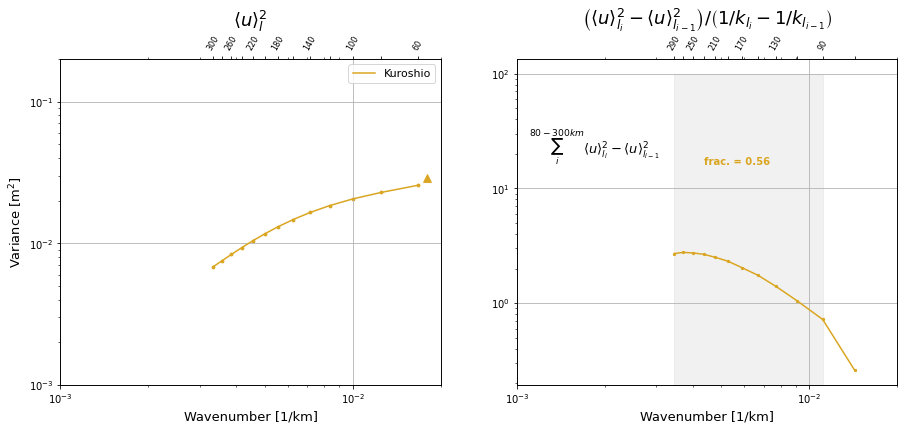

In [21]:
colors = ['#191970', '#DAA520', '#808000', 'r', 'c', 'm']
loc_var = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_G = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_B = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_spread = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_eke = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_sum_spread = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_win_sq = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_var_sum_sq = np.nan * np.ones((len(loc_points), len(coarsening_factors)))
loc_large_sc_var = np.nan * np.ones((len(loc_points)))
loc_tot_var = np.nan * np.ones((len(loc_points)))
for i in range(len(loc_points[0:5])):
    # within each box, find eke or other quantity (only take one value from the map...dont average again)
    ll = np.where((lat_bin_c > (location[i][2] + 1.25)) & (lat_bin_c < (location[i][3] - 1.25)))[0][0]
    kk = np.where((lon_bin_c > (location[i][0] + 1.25)) & (lon_bin_c < (location[i][1] - 1.25)))[0][0]   
    # ** still large to small ... optionally average over a certain time of the year ** 
    # average only in time 
    loc_var[i, :] = np.nanmean(mean_sla_smooth[:][:, kk, ll, :], axis=0)  # tuple(range(0, 3))
    loc_var_G[i, :] = np.nanmean(mean_sla_smoothG[:][:, kk, ll, :], axis=0)
    # loc_var_B[i, :] = np.nanmean(mean_sla_smoothB[:][:, kk, ll, :], axis=0)
    loc_var_eke[i, :] = np.nanmean(mean_diff0[:][:, kk, ll, :], axis=0)   # tuple(range(0, 3))
    loc_tot_var[i] = np.nanmean(mean_sla0[:][:, kk, ll])  # np.nanmean(mean_sla_total[kk][:, ll])
    
# loc_var = np.fliplr(loc_var)
# loc_var_spread = np.fliplr(loc_var_spread)
# loc_var_eke = np.fliplr(loc_var_eke)
# -- PLOT -- 
f, (ax3, ax) = plt.subplots(1, 2, figsize=(15,6))
ax2 = ax.twiny()
ax4 = ax3.twiny()
shaded_r = 80
shaded_l = 300
mi = np.where((band_centers > shaded_r) & (band_centers < shaded_l))[0]
ax.fill_between(1/np.array(band_centers[mi]), 100*np.ones(len(band_centers[mi])), color='#DCDCDC', alpha=0.4)  # sample_band[2:8]
y_pos = np.array([1.2, 1.6, 2.2, 2.9, 3.8])*10**(1)
for i in range(1,2):  # len(loc_points[0:5])
    ax3.scatter([1.8*10**(-2)], loc_tot_var[i], color=colors[i], s=60, marker="^")
    # ax.scatter([1.5*10**(-3) + i*2*10**(-8)], loc_large_sc_var[i], color=colors[i], s=60, marker="*")  
    
    # -- all
    # ax3.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 0:-1]), label=labely[i], color=colors[i])
    # ax3.scatter(1/np.array(band_centers[0:-1]), (loc_var[i, 0:-1]), color=colors[i])
    
    ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var[i, :]), label=labely[i], color=colors[i])
    # ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var_G[i, :]), label=labely[i] + ', Gaussian', color=colors[i], linestyle='--')
    # ax3.plot(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var_B[i, :]), label=labely[i] + ', boxcar', color=colors[i], linestyle='-.')
    ax3.scatter(1/np.array(coarsening_factors*hor_grid_spacing), (loc_var[i, :]), color=colors[i], s=8)

    # ax.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1]), label=labely[i], color=colors[i])
    ax.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), label=labely[i], color=colors[i])
    ax.scatter(1/np.array(band_centers[0:-1]), \
               (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
               color=colors[i], s=5)
    # ax.scatter(1/60, loc_var_eke[i, 0]/(1/10 - 1/60), color=colors[i]) # eke at scales less than 80 
    ax.plot(1/np.array(band_centers[0:-1]), (loc_var_G[i, 1:] - loc_var_G[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
            label=labely[i], color=colors[i], linestyle='--')  

    sample_band = (loc_var[i, 1:] - loc_var[i, 0:-1])
    ax.text(1/np.array(band_centers[3]), y_pos[i], \
            'frac. = ' + str(np.round(np.sum(sample_band[mi])/loc_tot_var[i], 2)), color=colors[i], fontweight='bold')
    
ax.text(1.1*10**(-3), 2*10**(1), r'$\sum_{i}^{80-300km} \langle u \rangle_{l_i}^2 - \langle u \rangle_{l_{i-1}}^2$', fontsize=13)   
ax.grid()
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1*10**(-3), 2*10**(-2)])
# ax3.set_ylim([1*10**(-1), 3*10**(0)])
ax3.set_ylim([1*10**(-3), 2*10**(-1)])
# ax3.set_ylim([2*10**(-3), 4*10**(-2)])
ax3.set_xlabel('Wavenumber [1/km]', fontsize=13)
ax3.set_ylabel(r'Variance [m$^2$]', fontsize=13)
ax3.set_title(r"$\langle u \rangle _l^2$", fontsize=18)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=11)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1*10**(-3), 2*10**(-2)])
# ax.set_ylim([1*10**(-1), 1*10**(2)])
# ax.set_ylim([1*10**(-3), 3*10**(1)])
ax2.set_xscale('log')
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(1/np.array(band_centers[0:-1]))
bcl = []
for i in range(len(band_centers[0:-1])):
    if np.mod(i, 2):
        bcl.append('')
    else:
        bcl.append(str(np.round(np.int(band_centers[i]))))
ax2.set_xticklabels(bcl, rotation=60, fontsize=8)
ax.set_xlabel('Wavenumber [1/km]', fontsize=13)
# ax.set_ylabel(r'Variance [m$^2$]', fontsize=13)
# ax.set_title(r"$\left( \langle u \rangle_{l_{i}}^2 - \langle u \rangle_{l_{i-1}}^2 \right)$", fontsize=18)
ax.set_title(r"$\left( \langle u \rangle_{l_{i}}^2 - \langle u \rangle_{l_{i-1}}^2 \right) / \left( 1/k_{l_i} - 1/k_{l_{i-1}} \right)$", fontsize=18)
ax4.set_xscale('log')
# ax4.set_xticks(1/np.array(band_centers[0:-1]))
ax4.set_xticks(1/np.array(coarsening_factors*hor_grid_spacing))
bcl = []
for i in range(len(coarsening_factors)):
    if np.mod(i, 2):
        bcl.append('')
    else:
        # bcl.append(str(np.round(np.int(band_centers[i]))))
        bcl.append(str(np.round(np.int(coarsening_factors[i]*hor_grid_spacing))))
ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(1/np.array(coarsening_factors*hor_grid_spacing))
ax4.set_xticklabels(bcl, rotation=60, fontsize=8)
ax3.grid()
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_eke_per_scale_banded_sharp_vs_g_single.jpg', dpi=400)

In [20]:
load_al = pickle.load(open('/Users/jakesteinberg/Desktop/al_meso_band_old.p', 'rb'))
load_al.keys()

dict_keys(['lon', 'lat', 'total_ke', 'total_variance', 'eke_160', 'meso_frac_80_300'])

In [169]:
# alternate sat comparison
# al, s3a 
load_al = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/al_meso_band.p', 'rb'))
load_s3a = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/s3a_meso_band.p', 'rb'))

# -- J2 - zonal mean 
v_in = np.where((lat_bin_c > -10) & (lat_bin_c < 10))[0]
mean_mf_mask_c = np.nanmean(mean_sla0,axis=0)  # meso_frac2.copy() 
mean_mf_mask_c[:, v_in] = np.nan
# test = mean_mf_mask_c*loc_tot_var_all
# -- AL
mean_mf_mask_al = np.nanmean(load_al['total_ke'],axis=0) # ['meso_frac_80_300']
mean_mf_mask_al[:, v_in] = np.nan
# test_al = mean_mf_mask_al*load_al['total_variance']
# -- s3a
mean_mf_mask_s3a = np.nanmean(load_s3a['total_ke'],axis=0) # ['meso_frac_80_300']
mean_mf_mask_s3a[:, v_in] = np.nan
# test_s3a = mean_mf_mask_s3a*load_s3a['total_variance']

In [177]:
np.shape(lon_bin_c)

(360,)

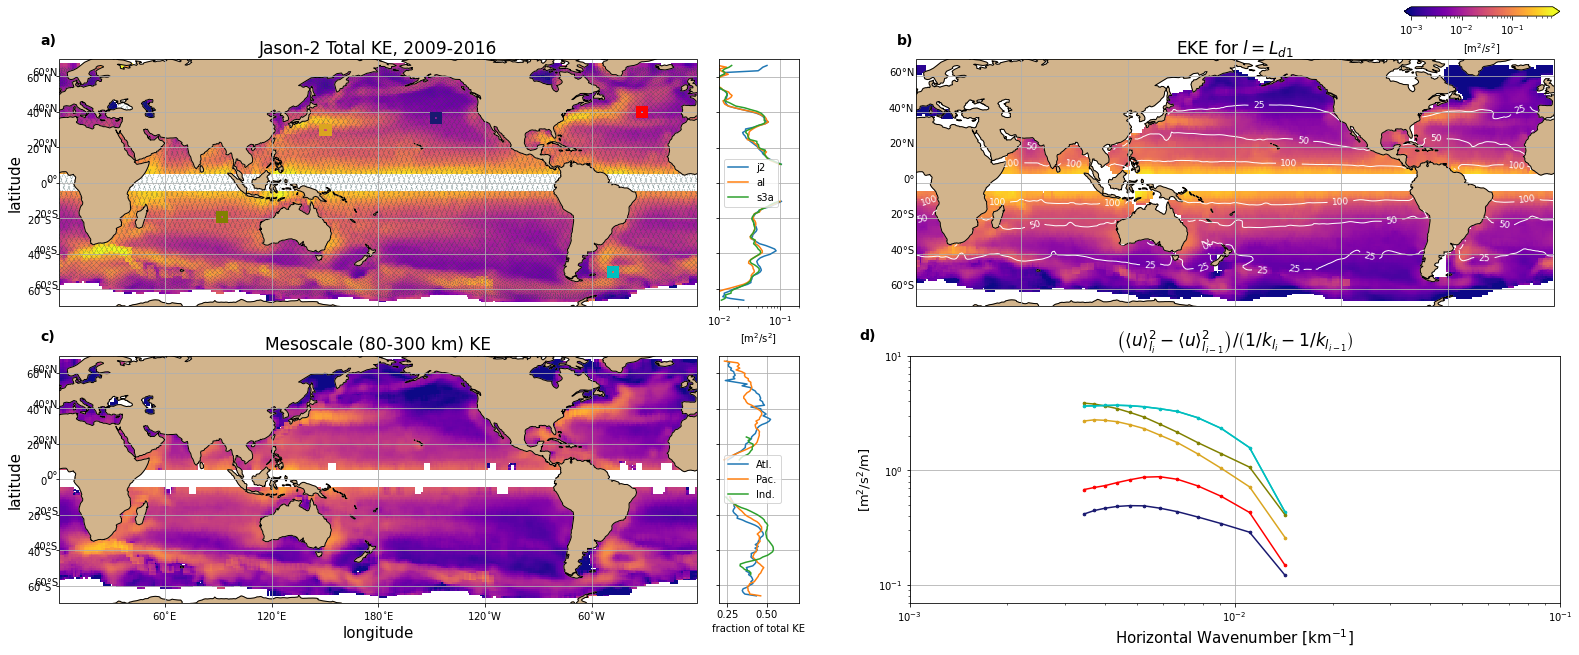

In [184]:
land_col = '#D3D3D3'
lev1 = np.arange(0.001, 0.65, 0.001)
lev2 = np.arange(0.15, 0.75, 0.001)
dlev1 = np.arange(1, 1001, 1)
tcmap = plt.get_cmap('plasma')
tcmap2 = plt.get_cmap('plasma')
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]

# -- unfiltered KE 
mean_raw_mask = np.nanmean(mean_sla0,axis=0)       
# -- EKE 
this_s = np.where(coarsening_factors==8)[0]
mean_eke1_mask = np.squeeze(np.nanmean(mean_diff0[:, :, :, this_s], axis=0)) 
# -- EKE LD1
mean_eke2_mask = np.squeeze(np.nanmean(mean_diff0Ld, axis=0))            # EKE <= Ld1
# -- EKE 80-300km
mean_meso_mask = meso_frac2.copy()                    # KE in 80-300 km  
mean_meso_frac_mask = meso_frac2/loc_tot_var_all      # KE frac in 80-300 km 
mean_submf_mask = submeso_frac.copy() 

mean_raw_mask[:, v_in] = np.nan
mean_eke1_mask[:, v_in] = np.nan
mean_eke2_mask[:, v_in] = np.nan
mean_meso_mask[:, v_in] = np.nan
v_in = np.where((lat_bin_c > -10) & (lat_bin_c < 10))[0]
mean_meso_frac_mask[:, v_in] = np.nan
mean_submf_mask[:, v_in] = np.nan


# -- new figure design
f = plt.figure(figsize=(27,10))  # , constrained_layout=True)
gs = GridSpec(2, 16, figure=f)
ax1 = f.add_subplot(gs[0, 0:7], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = f.add_subplot(gs[0, 9:], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = f.add_subplot(gs[1, 0:7], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = f.add_subplot(gs[1, 9:])
# added small plots
ax5 = f.add_subplot(gs[0, 7:8])
ax6 = f.add_subplot(gs[1, 7:8])

# lon_comp = lon_bins[1:-1]
lon_comp = lon_bin_c.copy()
comp_in = np.where((lon_comp < 225) | (lon_comp > 290))[0]
ax5.plot(np.nanmean(mean_mf_mask_c[comp_in, :], axis=0), lat_bin_c, label='j2')  # test 
ax5.plot(np.nanmean(mean_mf_mask_al[comp_in, :], axis=0), load_al['lat'], label='al') # test_al
ax5.plot(np.nanmean(mean_mf_mask_s3a[comp_in, :], axis=0), load_s3a['lat'], label='s3a') # test_s3a
# ax5.set_xlim([0.0001, .025])
ax5.set_xlim([0.01, 0.2])
ax5.set_xscale('log')
ax5.set_ylim([lat_s-0, lat_n+0])
ax5.set(yticklabels=[])
ax5.set_xlabel('[m$^2$/s$^2$]')
# ax5.set_title('80-300 km KE', fontsize=11)
handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels, fontsize=10, loc='center left')
ax5.grid()

# MAIN figures 
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
data_coords2 = {'latitude': lat_bins[1:-1], 'longitude': lon_bins[1:-1]}
lon_xr = np.where((lon_bin_c > lon_w) & (lon_bin_c < lon_e))[0]
lat_xr = np.where((lat_bin_c > lat_s) & (lat_bin_c < lat_n))[0]
lon_xr2 = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr2 = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
test_xr = xr.DataArray(data=np.transpose(mean_raw_mask), name='total_ke', dims=['latitude', 'longitude'], coords=data_coords)
test_Ld_xr = xr.DataArray(data=np.transpose(mean_eke2_mask), name='Ld_eke', dims=['latitude', 'longitude'], coords=data_coords)
test_meso_xr = xr.DataArray(data=np.transpose(mean_meso_mask), name='meso_ke', dims=['latitude', 'longitude'], coords=data_coords2)

axp = test_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax1,transform=ccrs.PlateCarree(), \
                                                             norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), \
                                                             cmap=tcmap2, zorder=0, add_colorbar=False, add_labels=True)
ax1.set_title(r"Jason-2 Total KE, 2009-2016", fontsize=17)
test_Ld_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax2,transform=ccrs.PlateCarree(), \
                                                             norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), \
                                                             cmap=tcmap2, zorder=0, add_colorbar=False, add_labels=True)
test_meso_xr.isel(longitude=lon_xr2, latitude=lat_xr2).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), \
                                                             cmap=tcmap2, zorder=0, add_colorbar=False, add_labels=True)


for i in range(len(lon_record)):
    ax1.scatter(lon_record[i][::4], lat_record[i][::4], color='#2F4F4F', zorder=1, s=0.01, transform=ccrs.PlateCarree())
# #FAEBD7
for i in range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax1.plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=5, transform=ccrs.PlateCarree())
    ax1.plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=5, transform=ccrs.PlateCarree())
    ax1.plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=5, transform=ccrs.PlateCarree())
    ax1.plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=5, transform=ccrs.PlateCarree())

# -- ke in mesoscale -- 
# ax3.pcolor(x4['lon'].values, x4['lat'].values, lander, vmin=0.2, vmax=0.3, cmap=land_cmap, zorder=1)   
# axp = ax3.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_meso_mask), \
#                  norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)
ax3.set_title(r"Mesoscale (80-300 km) KE", fontsize=17)
# -- frac of ke in mesoscale -- 
atl_in = np.where((lon_bins[1:-1] > 280) & (lon_bins[1:-1] < 360))[0]
pac_in = np.where((lon_bins[1:-1] > 120) & (lon_bins[1:-1] < 270))[0]
ind_in = np.where((lon_bins[1:-1] > 50) & (lon_bins[1:-1] < 120))[0]
ind_in2 = np.where((lat_bins[1:-1] > -55) & (lat_bins[1:-1] < 25))[0]
ax6.plot(np.nanmean(mean_meso_frac_mask[atl_in, :], axis=0), lat_bins[1:-1], label='Atl.')
ax6.plot(np.nanmean(mean_meso_frac_mask[pac_in, :], axis=0), lat_bins[1:-1], label='Pac.')
ax6.plot(np.nanmean(mean_meso_frac_mask[ind_in][:, ind_in2], axis=0), lat_bins[1:-1][ind_in2], label='Ind.')
ax6.set_xlim([0.2, 0.7])
ax6.set_ylim([lat_s-0, lat_n+0])
ax6.set(yticklabels=[])
ax6.set_xlabel('fraction of total KE')
handles, labels = ax6.get_legend_handles_labels()
ax6.legend(handles, labels, fontsize=10, loc='center left')
ax6.grid()

# -- Ld1 --
ax2.set_title(r"EKE for $l = L_{d1}$", fontsize=17)
dr = ax2.contour(lon_bin_c, lat_bin_c, def_rad, \
                 levels=[25, 50, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax2.clabel(dr, fontsize=9, inline=1, fmt = '%1.0f')

# -- KE frac -- 
# ax4.pcolor(x4['lon'].values, x4['lat'].values, lander, vmin=0.2, vmax=0.3, cmap=land_cmap, zorder=1)   
# axpmf = ax4.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_ms_mask), \
#                  norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)  # cmocean.cm.deep_r

# -- spectral analogue -- 
for i in range(len(loc_points)-1):
    ax4.scatter(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), s=7, color=colors[i])
    ax4.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), color=colors[i])
    # ax4.scatter(1/np.array(band_centers[0:-1]), (loc_var_G[i, 1:] - loc_var_G[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
    #          s=7, color=colors[i])
    # ax4.plot(1/np.array(band_centers[0:-1]), (loc_var_G[i, 1:] - loc_var_G[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
    #          color=colors[i], linestyle='--')
ax4.plot(1/np.array(band_centers[0:-1]), (loc_var[i, 1:] - loc_var[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
         label='taper', color=colors[i],)
# ax4.plot(1/np.array(band_centers[0:-1]), (loc_var_G[i, 1:] - loc_var_G[i, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1])), \
#          label='Gaussian', color=colors[i], linestyle='--')
ax4.set_ylabel('[m$^2$/s$^2$/m]', fontsize=13)
# handles, labels = ax4.get_legend_handles_labels()
# ax4.legend(handles, labels, fontsize=14)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim([1*10**(-3), 1*10**(-1)])
ax4.set_ylim([7*10**(-2), 1*10**(1)])
ax4.set_xlabel('Horizontal Wavenumber [km$^{-1}$]', fontsize=15)
ax4.grid()
ax4.set_title(r"$\left( \langle u \rangle_{l_{i}}^2 - \langle u \rangle_{l_{i-1}}^2 \right) / \left( 1/k_{l_i} - 1/k_{l_{i-1}} \right)$", fontsize=17)

cbpos = [0.82, 0.94, 0.08, 0.013]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both', label='[m$^2$/$s^2$]')
ax1.text(-190, 78, 'a)', fontweight='bold', fontsize=14)
ax2.text(-190, 78, 'b)', fontweight='bold', fontsize=14)
ax3.text(-190, 78, 'c)', fontweight='bold', fontsize=14)
ax4.text(7*10**(-4), 1.4*10**1, 'd)', fontweight='bold', fontsize=14)
# ax5.text(0.00003, 78, 'b)', fontweight='bold', fontsize=14)
# ax6.text(0.07, 78, 'e)', fontweight='bold', fontsize=14)
for ax in ax1, ax2, ax3:
    ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    ax.coastlines()
    ax.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), np.nanmin(lat_bin_c[lat_xr]), np.nanmax(lat_bin_c[lat_xr])], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabels_bottom = False
ax1.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax1.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'])
ax1.set_ylabel('latitude',fontsize=15)
ax3.set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax3.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'])
ax3.set_ylabel('latitude',fontsize=15)
ax3.set_xticks([-120, -60, 0, 60, 120])
ax3.set_xticklabels(['60$^{\circ}$E', '120$^{\circ}$E', '180$^{\circ}$E', '120$^{\circ}$W', '60$^{\circ}$W'])
ax3.set_xlabel('longitude',fontsize=15)
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_along_track_gridding_cart.jpg', dpi=550)

In [107]:
np.shape(mean_meso_frac_mask[ind_in][:, ind_in2])

(69, 79)

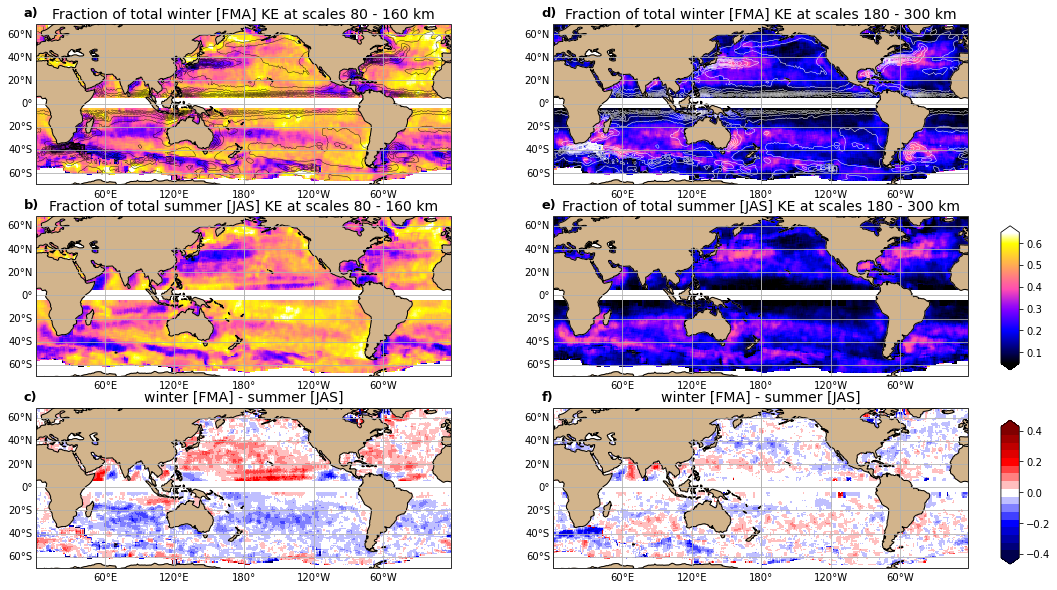

In [50]:
# seaonal changes in percent of energy in bands
land_col = '#D3D3D3'
lev2 = np.arange(0.05, 0.65, 0.001)
dlev1 = np.arange(1, 1001, 1)
tcmap2 = plt.get_cmap('gnuplot2')
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]

# -- unfiltered KE 
mean_raw_mask = np.nanmean(mean_sla0,axis=0) 
mean_raw_mask[:, v_in] = np.nan
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
test_xr = xr.DataArray(data=np.transpose(mean_raw_mask), name='total_ke', dims=['latitude', 'longitude'], coords=data_coords)

mean_mf_mask0 = meso_frac0.copy() 
mean_mfwin_mask0 = smaller_frac0_win.copy()
mean_mfsum_mask0 = smaller_frac0_sum.copy()
mean_mf_mask1 = meso_frac1.copy() 
mean_mfwin_mask1 = smaller_frac1_win.copy()
mean_mfsum_mask1 = smaller_frac1_sum.copy()

mean_mf_mask0[:, v_in] = np.nan
mean_mfwin_mask0[:, v_in] = np.nan
mean_mfsum_mask0[:, v_in] = np.nan
mean_mf_mask1[:, v_in] = np.nan
mean_mfwin_mask1[:, v_in] = np.nan
mean_mfsum_mask1[:, v_in] = np.nan

bad_check = mean_mfwin_mask1 - mean_mfsum_mask1
for i in range(np.shape(mean_mfwin_mask1)[1]):
    bad = np.where(np.abs(bad_check[:, i]) > .34)[0]
    bad_check[bad, i] = np.nan
    bad_check[bad, i] = np.nan
land_cmap2 = plt.cm.get_cmap('viridis')
land_cmap2.set_over('#D3D3D3')

data_coords = {'latitude': lat_bins[1:-1], 'longitude': lon_bins[1:-1]}
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
mfwin_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask0), \
                                      name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfsum_xr = xr.DataArray(data=np.transpose(mean_mfsum_mask0), \
                                      name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwinsum_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0), \
                           name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwin1_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask1), \
                                      name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfsum1_xr = xr.DataArray(data=np.transpose(mean_mfsum_mask1), \
                                      name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwinsum1_xr = xr.DataArray(data=np.transpose(bad_check), \
                           name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)  # mean_mfwin_mask1 - mean_mfsum_mask1

f, ax = plt.subplots(3,2,figsize=(17,10),\
                     subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# -- column 0 
axpmf = mfwin_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,0],transform=ccrs.PlateCarree(), \
                                                             vmin=lev2[0], vmax=lev2[-1], \
                                                             cmap=tcmap2, zorder=0, add_colorbar=False)
ax[0,0].contour(lon_bin_c,lat_bin_c,np.transpose(mean_raw_mask),transform=ccrs.PlateCarree(), \
                                                        levels=np.arange(0.01,1,0.04), \
                                                        linewidths=0.4,colors='k',zorder=1)
ax[0,0].set_title(r"Fraction of total winter [FMA] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + " km", fontsize=14)

mfsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[1,0],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[1,0].set_title(r"Fraction of total summer [JAS] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + " km", fontsize=14)
 
mfwinsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[2,0],transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)
ax[2,0].set_title(r"winter [FMA] - summer [JAS]", fontsize=14)
# # -- column 1
mfwin1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,1],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[0,1].contour(lon_bin_c,lat_bin_c,np.transpose(mean_raw_mask),transform=ccrs.PlateCarree(), \
                                                        levels=np.arange(0.01,1,0.04), \
                                                        linewidths=0.5,colors='w',zorder=1)
ax[0,1].set_title(r"Fraction of total winter [FMA] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + " km", fontsize=14)

mfsum1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[1,1],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[1,1].set_title(r"Fraction of total summer [JAS] KE at scales " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + " km", fontsize=14)
 
axpmfd = mfwinsum1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[2,1],transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)
ax[2,1].set_title(r"winter [FMA] - summer [JAS]", fontsize=14)

for axi in ax.flatten():
    axi.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    axi.coastlines()
    axi.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), \
                np.nanmin(lat_bin_c[lat_xr]), np.nanmax(lat_bin_c[lat_xr])], crs=ccrs.PlateCarree())
    gl = axi.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False

cbpos = [0.92, 0.4, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmf, cax=cax, orientation='vertical', extend='both')
cbpos = [0.92, 0.13, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axpmfd, cax=cax, orientation='vertical', extend='both')
ax[0,0].text(-190, 75, 'a)', fontweight='bold', fontsize=13)
ax[1,0].text(-190, 75, 'b)', fontweight='bold', fontsize=13)
ax[2,0].text(-190, 75, 'c)', fontweight='bold', fontsize=13)
ax[0,1].text(-190, 75, 'd)', fontweight='bold', fontsize=13)
ax[1,1].text(-190, 75, 'e)', fontweight='bold', fontsize=13)
ax[2,1].text(-190, 75, 'f)', fontweight='bold', fontsize=13)
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_along_track_gridding_seasonal_percent_ke_2.jpg', dpi=550)


In [53]:
np.nanmax(mfwinsum_xr)

2.427594259352048

In [30]:
win_m_sum_80_160 = np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0) # lon_bins[1:-1], lat_bins[1:-1]

(139, 359)

In [20]:
save_p = 1
if save_p > 0:
    outputs = {'lon': lon_bin_c, 'lat': lat_bin_c, \
               'total_ke': mean_sla0, \
               'total_variance': loc_tot_var_all, \
               'eke_160': mean_eke1_mask, \
               'meso_frac_80_300': meso_frac2}
    pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/' + this_sat + '_meso_band.p', 'wb'))

In [23]:
sample_band = (loc_var[2, 1:] - loc_var[2, 0:-1])
print('sum of filtered variances = ' + str(np.sum(sample_band)))
print('variance between 240km and 80km = ' + str(np.sum(sample_band[2:9])))
print('total unfiltered variance = ' + str(loc_tot_var[2]))
print(coarsening_factors*10)
# print(band_ends)
print(band_centers)

sum of filtered variances = 0.025503295823011682
variance between 240km and 80km = 0.012768663559466027
total unfiltered variance = 0.03793066169013173
[150. 140. 130. 120. 110. 100.  90.  80.  70.  60.  50.  40.  30.]
[290. 270. 250. 230. 210. 190. 170. 150. 130. 110.  90.  70.  40.]


In [25]:
band_ends = np.flip(band_ends)
band_ends

array([ 60.,  80., 100., 120., 140., 160., 180., 200., 220., 240., 260.,
       280., 300.])

In [37]:
# AVISO CHECK 
aviso10 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2010_jan_may.nc')
aviso11 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2010_aug_nov.nc')
aviso20 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2011_jan_may.nc')
aviso21 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2011_aug_nov.nc')
aviso30 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2012_jan_may.nc')
aviso31 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2012_aug_nov.nc')
aviso40 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2013_jan_may.nc')
aviso41 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2013_aug_nov.nc')
aviso50 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2014_jan_may.nc')
aviso51 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/merged/dataset-duacs-rep-global-merged-allsat-phy-l4_2014_aug_nov.nc')
aviso_lon = aviso10['longitude'].data
aviso_lat = aviso10['latitude'].data

In [38]:
aviso_time = aviso10.time.data
a_u = np.concatenate((aviso10.ugos.data, aviso20.ugos.data, aviso30.ugos.data, aviso40.ugos.data, aviso50.ugos.data), axis=0)
a_v = np.concatenate((aviso10.vgos.data, aviso20.vgos.data, aviso30.vgos.data, aviso40.vgos.data, aviso50.vgos.data), axis=0)

In [39]:
a_k = 0.5 * (np.nanmean(a_u**2, axis=0) + np.nanmean(a_v**2, axis=0))

In [40]:
# AVISO by season
a_win_in = np.arange(31,120)  # feb-apr
a_sum_in = np.arange(0,92)  # aug-oct
a_u_march = np.concatenate((aviso10.ugos.data[a_win_in], \
                            aviso20.ugos.data[a_win_in], aviso30.ugos.data[a_win_in], \
                            aviso40.ugos.data[a_win_in], aviso50.ugos.data[a_win_in]), axis=0)
a_v_march = np.concatenate((aviso10.vgos.data[a_win_in], \
                            aviso20.vgos.data[a_win_in], aviso30.vgos.data[a_win_in], \
                            aviso40.vgos.data[a_win_in], aviso50.vgos.data[a_win_in]), axis=0)

a_u_sept = np.concatenate((aviso11.ugos.data[a_sum_in], \
                           aviso21.ugos.data[a_sum_in], aviso31.ugos.data[a_sum_in], \
                           aviso41.ugos.data[a_sum_in], aviso51.ugos.data[a_sum_in]), axis=0)
a_v_sept = np.concatenate((aviso11.vgos.data[a_sum_in], \
                           aviso21.vgos.data[a_sum_in], aviso31.ugos.data[a_sum_in], \
                           aviso41.vgos.data[a_sum_in], aviso51.ugos.data[a_sum_in]), axis=0)
march_ke = 0.5 * (np.nanmean(a_u_march**2, axis=0) + np.nanmean(a_v_march**2, axis=0))
sept_ke = 0.5 * (np.nanmean(a_u_sept**2, axis=0) + np.nanmean(a_v_sept**2, axis=0))

In [41]:
# smooth aviso 
a_ke = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
a_ke_win = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
a_ke_sum = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2
        
        alon_in = np.where((aviso_lon >= this_lon0) & (aviso_lon <= this_lon1))[0]
        alat_in = np.where((aviso_lat >= this_lat0) & (aviso_lat <= this_lat1))[0]
        a_ke_win[i, j] = np.nanmean(march_ke[alat_in, :][:, alon_in]) 
        a_ke_sum[i, j] = np.nanmean(sept_ke[alat_in, :][:, alon_in]) 
        a_ke[i, j] = np.nanmean(a_k[alat_in, :][:, alon_in])

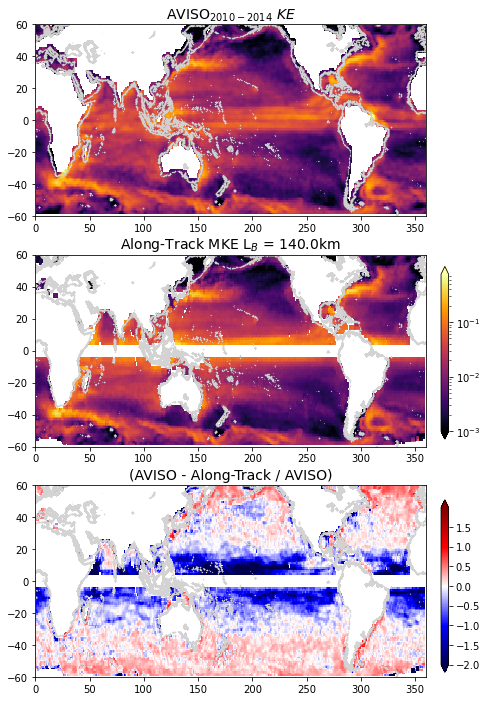

In [64]:
# what smoothing of at data is needed to reproduce aviso 
tcmap = plt.get_cmap('inferno')
tcmap2 = plt.get_cmap('seismic')
land_col = '#D3D3D3'
lev1 = np.arange(0.001, 0.75, 0.001)
lev2 = np.arange(-2, 2, 0.001)
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]
mean_mke_mask = np.nanmean(mean_sla_smooth7, axis=0) 

f, (ax1,ax2,ax3) = plt.subplots(3,1,sharey=True, figsize=(7,12))
ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(a_ke), norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), \
                 cmap=tcmap, zorder=0)
ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_mke_mask), \
                 norm=LogNorm(vmin=lev1[0], vmax=lev1[-1]), zorder=0, cmap=tcmap)
ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp2 = ax3.pcolor(lon_bins, lat_bins, np.transpose((a_ke - mean_mke_mask)/a_ke), \
                 vmin=lev2[0], vmax=lev2[-1], zorder=0, cmap=tcmap2)
# vmin=diff_lev1[0], vmax=diff_lev1[-1]
ax1.set_title(r"AVISO$_{2010-2014}$ $KE$", fontsize=14)
ax2.set_title(r"Along-Track MKE L$_B$ = " + str(band_ends[4]) + "km", fontsize=14)
ax3.set_title(r"(AVISO - Along-Track / AVISO)", fontsize=14)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax2.set_xlim([lon_w, lon_e])
ax2.set_ylim([lat_s, lat_n])
ax3.set_xlim([lon_w, lon_e])
ax3.set_ylim([lat_s, lat_n])

cbpos = [0.93, 0.4, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
cbpos = [0.93, 0.13, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp2, cax=cax, orientation='vertical', extend='both')
plt.show()

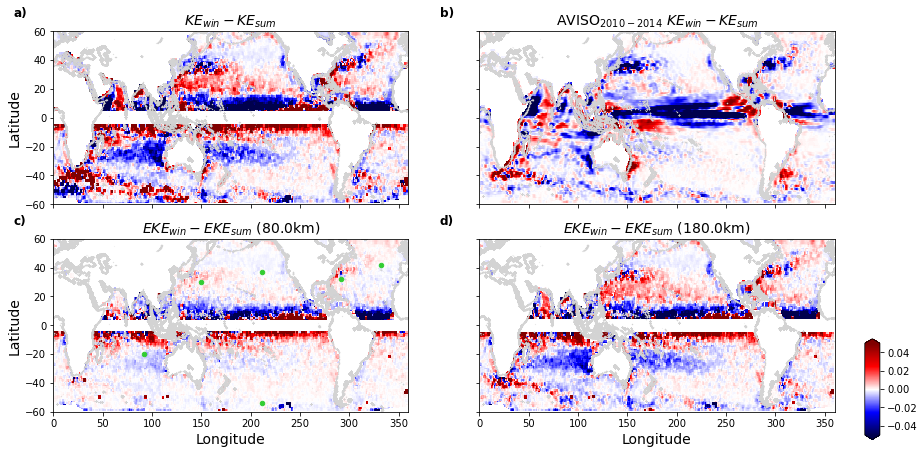

In [356]:
# EKE summer vs. winter
# diff_lev = np.arange(0.00001, 0.01, 0.00001)
# diff_lev1 = np.arange(0.01, 10, 0.0001)
diff_lev1 = np.arange(-.05, 0.05, 0.0001)
# diff_lev1 = np.arange(-10, 10, 0.0001)
# tcmap = cmocean.cm.thermal
tcmap = plt.get_cmap('seismic')
land_col = '#D3D3D3'

# plot, excluding equator 
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]
mean_raw_mask = np.nanmean(mean_sla0[win_in],axis=0) - np.nanmean(mean_sla0[sum_in], axis=0)   # (mean_diff0_7 - mean_diff1_7).copy()
mean_v4_mask = np.nanmean(mean_diff0_4[win_in],axis=0) - np.nanmean(mean_diff0_4[sum_in], axis=0)   # (mean_diff0_7 - mean_diff1_7).copy()
mean_v7_mask = np.nanmean(mean_diff0_7[win_in],axis=0) - np.nanmean(mean_diff0_7[sum_in], axis=0)   # (mean_diff0_7 - mean_diff1_7).copy()
mean_v8_mask = np.nanmean(mean_diff0_8[win_in],axis=0) - np.nanmean(mean_diff0_8[sum_in], axis=0)   # (mean_diff0_8 - mean_diff1_8).copy()
mean_v9_mask = np.nanmean(mean_diff0_9[win_in],axis=0) - np.nanmean(mean_diff0_9[sum_in], axis=0)   # (mean_diff0_9 - mean_diff1_9).copy()
mean_v10_mask = np.nanmean(mean_diff0_10[win_in],axis=0) - np.nanmean(mean_diff0_10[sum_in], axis=0)  # (mean_diff0_10 - mean_diff1_10).copy()
mean_v11_mask = np.nanmean(mean_diff0_11[win_in],axis=0) - np.nanmean(mean_diff0_11[sum_in], axis=0)  # (mean_diff0_11 - mean_diff1_11).copy()
mean_v12_mask = np.nanmean(mean_diff0_12[win_in],axis=0) - np.nanmean(mean_diff0_12[sum_in], axis=0)  # (mean_diff0_12 - mean_diff1_12).copy()
mean_v13_mask = np.nanmean(mean_diff0_13[win_in],axis=0) - np.nanmean(mean_diff0_13[sum_in], axis=0)  # (mean_diff0_13 - mean_diff1_13).copy()
mean_raw_mask[:, v_in] = np.nan
mean_v7_mask[:, v_in] = np.nan
mean_v8_mask[:, v_in] = np.nan
mean_v9_mask[:, v_in] = np.nan
mean_v10_mask[:, v_in] = np.nan
mean_v11_mask[:, v_in] = np.nan
mean_v12_mask[:, v_in] = np.nan
mean_v13_mask[:, v_in] = np.nan

f, ((ax3, ax4), (ax1, ax2)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14, 7))

ax1.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v4_mask), \
                 vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_sla), levels=diff_lev, cmap=tcmap, linewidths=0.5)
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_title(r"$EKE_{win} - EKE_{sum}$ (" + str(band_ends[1]) + "km)", fontsize=14)  
for i in range(np.shape(loc_points)[0]):
    ax1.scatter(loc_points[i, 1], loc_points[i, 0], s=20, color='#32CD32', zorder=2)
ax1.set_ylabel('Latitude', fontsize=14)

ax2.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v9_mask), \
                 vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
ax2.set_title(r"$EKE_{win} - EKE_{sum}$ (" + str(band_ends[6]) + "km)", fontsize=14)

ax3.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax3.pcolor(lon_bins, lat_bins, np.transpose(mean_raw_mask), \
                 vmin=diff_lev1[0], vmax=diff_lev1[-1], zorder=0, cmap=tcmap)
ax3.set_title(r"$KE_{win} - KE_{sum}$", fontsize=14)
ax1.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)

ax4.scatter(x4['lon'].values, x4['lat'].values, color=land_col, zorder=1, s=0.01)
axp = ax4.pcolor(lon_bin_c, lat_bin_c, np.transpose(a_ke_win - a_ke_sum), vmin=diff_lev1[0], vmax=diff_lev1[-1], cmap=tcmap, zorder=0)
ax4.set_title(r"AVISO$_{2010-2014}$ $KE_{win} - KE_{sum}$", fontsize=14)
ax2.set_xlabel('Longitude', fontsize=14)
cbpos = [0.93, 0.07, 0.015, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both')
ax1.text(-40, 70, 'c)', fontweight='bold', fontsize=12)
ax3.text(-40, 70, 'a)', fontweight='bold', fontsize=12)
ax2.text(-40, 70, 'd)', fontweight='bold', fontsize=12)
ax4.text(-40, 70, 'b)', fontweight='bold', fontsize=12)
plt.show()
# f.savefig(this_sat + '_sla_scales.jpg', dpi=400)
# f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_winter_summer_w_aviso.jpg', dpi=400)

In [378]:
np.shape(time_record[gid])
from datetime import datetime
str(datetime.utcfromtimestamp(time_record[gid][90]))[0:10]
print(len(aviso20.time.data))
aviso20.time.data[89]  # .ugos.data

'2011-03-31'

In [411]:
from scipy.interpolate import griddata
np.shape(aviso20.ugos.data[89])
test_u = aviso20.ugos.data[89]
test_v = aviso20.vgos.data[89]
aviso_lon_grid, aviso_lat_grid = np.meshgrid(aviso_lon, aviso_lat)
points = np.concatenate( (aviso_lon_grid.flatten()[:, None], aviso_lat_grid.flatten()[:, None]), axis=1)
values_u = test_u.flatten()
values_v = test_v.flatten()
lon_sel = lon_record[gid]
lat_sel = lat_record[gid]
X0 = lon_sel
Y0 = lat_sel
aviso_at_u = griddata(points, values_u, (X0, Y0))
aviso_at_v = griddata(points, values_v, (X0, Y0))

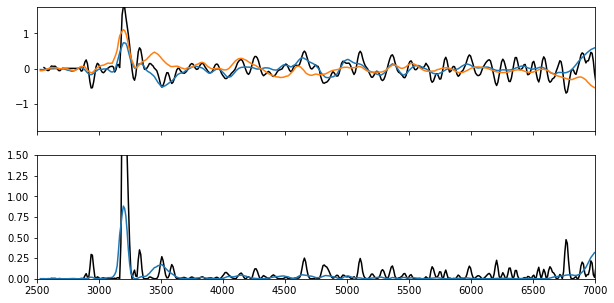

In [419]:
# extract AVISO along single track of j2 
# track = 24
# pass = 10
t_i = np.array([24.0])
gid = np.where(track_record == t_i)[0][0]
pass_index = 5
lon_sel = lon_record[gid]
lat_sel = lat_record[gid]
dist_sel = dist[gid]
f, (ax, ax2)= plt.subplots(2, 1, sharex=True, figsize=(10, 5))
ax.plot(dist_sel, vel[gid][90, :], color='k')
ax.plot(dist_sel, aviso_at_u)
ax.plot(dist_sel, aviso_at_v)
ax2.plot(dist_sel, vel[gid][90, :]**2, color='k')
ax2.plot(dist_sel, 0.5*(aviso_at_u**2 + aviso_at_v**2))
ax.set_ylim([-1.75, 1.75])
ax.set_xlim([2500, 7000])
ax2.set_ylim([0, 1.5])
plt.show()

In [422]:
outputs = {'aviso_u_at': aviso_at_u, 'aviso_v_at': aviso_at_v, \
           'at_dist': dist_sel, 'at_lon': lon_sel, 'at_lat': lat_sel}
pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/' + this_sat + \
                          '_aviso_interp_to_track_24_31mar2011.p', 'wb'))

In [26]:
# DEFORMATION RADIUS & RHINES SCALE
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc') 
c98_1 = c98['values'].data
def_rad = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
rhines = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
for i in range(len(lat_bin_c)):
    for j in range(len(lon_bin_c)):
        c_in = np.where((c98_1[:, 0] > (lat_bin_c[i] - 2)) & (c98_1[:, 0] < (lat_bin_c[i] + 2)) & \
                 (c98_1[:, 1] > (lon_bin_c[j] - 2)) & (c98_1[:, 1] < (lon_bin_c[j] + 2)))[0]
        if len(c_in) > 1:
            def_rad[i, j] = np.nanmean(c98_1[c_in, 3])
        beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_bin_c[i]))/(6356752)
        rhines[i, j] = np.sqrt(np.sqrt(mean_sla_total[j,i])/beta)

In [27]:
# ARGO MLD 
f_argo_mld = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_mixedlayers_monthlyclim_12112019.nc'
argo_mld = xr.open_dataset(f_argo_mld)
mld_lon = argo_mld['lon'].data
mld_lat = argo_mld['lat'].data
mld_mo = argo_mld['month'].data
mld = argo_mld['mld_da_mean'].data
mld_t = argo_mld['mlt_da'].data
mld_s = argo_mld['mls_da'].data
max_mo = np.nan * np.ones((np.shape(mld)[0], np.shape(mld)[1]))
min_mo = np.nan * np.ones((np.shape(mld)[0], np.shape(mld)[1]))
min_den = np.nan * np.ones((np.shape(mld)[0], np.shape(mld)[1]))
max_den = np.nan * np.ones((np.shape(mld)[0], np.shape(mld)[1]))
for i in range(np.shape(mld)[0]):
    for j in range(np.shape(mld)[1]):
        if np.sum(np.isnan(mld[i,j,:])) < 11:
            max_mo[i,j] = mld[i,j,np.where(mld[i,j,:] == np.nanmax(mld[i,j,:]))[0]]
            min_mo[i,j] = mld[i,j,np.where(mld[i,j,:] == np.nanmin(mld[i,j,:]))[0]]
            this_den = gsw.sigma0(mld_s[i,j,:], mld_t[i,j,:])
            min_den[i,j] = np.nanmin(this_den)
            max_den[i,j] = np.nanmax(this_den)
mld_energy = min_mo*(max_den-min_den) + 0.5*(max_mo-min_mo)*(max_den-min_den)
mld_change = max_mo-min_mo

mld_energy_smooth = np.nan * np.ones(np.shape(mld_energy))
for i in range(np.shape(mld)[0]):
    ff1 = Filter('Gaussian', [mld_energy[i,:][None,:]], 1, 5, plot_filter=0) 
    mld_energy_smooth[i,:] = ff1[0]
for j in range(np.shape(mld)[1]):
    ff1 = Filter('Gaussian', [mld_energy_smooth[:,j][None,:]], 1, 5, plot_filter=0) 
    mld_energy_smooth[:,j] = ff1[0]

data_coords = {'latitude': mld_lat, 'longitude': mld_lon}
arg_mld = xr.DataArray(data=mld_energy_smooth, dims=['latitude', 'longitude'], coords=data_coords)

Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>

Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>

Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>

Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 7 If d>

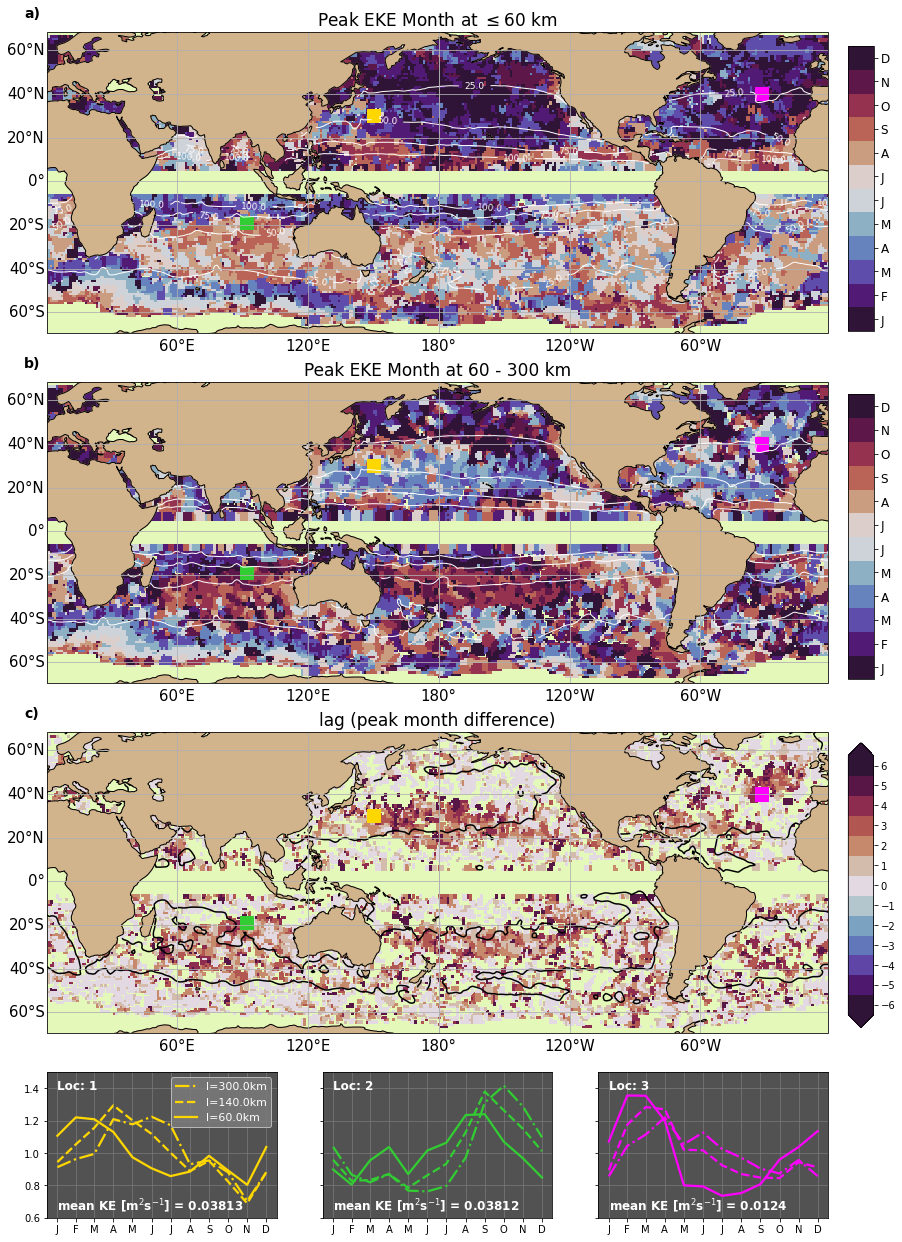

In [116]:
# -- peak eke month -- 
# scales to map
scale1 = np.where(coarsening_factors == 3)[0]
scale2 = np.where(coarsening_factors == 15)[0]
pct_diff_cutoff = 0.2
# find month that has most eke at each scale 
max_month_1 = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
max_month_2 = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
for i in range(np.shape(mean_diff0)[1]):
    for j in range(np.shape(mean_diff0)[2]):
        # -- scale1 (smaller)
        if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale1]))) & \
        (np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1]))/np.nanmean(mean_diff0[:, i, j, scale1]) > pct_diff_cutoff):
            this_ij = np.where(mean_diff0[:, i, j, scale1] == np.nanmax(mean_diff0[:, i, j, scale1]))[0]
            if len(this_ij) > 1:
                max_month_1[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_1[i, j] = this_ij + 1
        # -- scale2 (larger) 
        if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale2]))) & \
        (np.abs(np.nanmax(mean_diff0[:, i, j, scale2]) - np.nanmin(mean_diff0[:, i, j, scale2]))/np.nanmean(mean_diff0[:, i, j, scale2]) > pct_diff_cutoff):
            test = mean_diff0[:, i, j, scale2] - mean_diff0[:, i, j, scale1]  # difference between scales 
            this_ij = np.where(test == np.nanmax(test))[0]
            # this_ij = np.where(mean_diff0_11[:, i, j] == np.nanmax(mean_diff0_11[:, i, j]))[0]
            if len(this_ij) > 1:
                max_month_2[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_2[i, j] = this_ij + 1

# put output in xarray
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr_s = np.where(((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < -5)))[0]
lat_xr_n = np.where(((lat_bins[1:-1] > 5) & (lat_bins[1:-1] < lat_n)))[0]
mm1_xr = xr.DataArray(data=np.transpose(max_month_1), \
                                      name='less_than_80', dims=['latitude', 'longitude'], coords=data_coords)
mm2_xr = xr.DataArray(data=np.transpose(max_month_2), \
                                      name='less_than_80', dims=['latitude', 'longitude'], coords=data_coords)
eqq = np.where((lat_bins[1:-1] > -2) & (lat_bins[1:-1] < 2))[0]

# ------------------------
# -- PLOT --        
# ------------------------
f = plt.figure(figsize=(14, 22))  # , constrained_layout=True)
gs = GridSpec(7, 3, figure=f)
ax1 = f.add_subplot(gs[0:2, :], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = f.add_subplot(gs[2:4, :], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = f.add_subplot(gs[4:6, :], projection=ccrs.PlateCarree(central_longitude=180))
aa1 = f.add_subplot(gs[6, 0])
aa2 = f.add_subplot(gs[6, 1])
aa3 = f.add_subplot(gs[6, 2])
# - 1 - 
axp0 = mm1_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False, extend="neither")
axp0 = mm1_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False, extend="neither")
ax1.set_title('Peak EKE Month at $\leq$' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' km', fontsize=17)
dr = ax1.contour(lon_bin_c, lat_bin_c, def_rad, \
                 levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax1.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')

# - 2-  
axp = mm2_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
axp = mm2_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
ax2.contour(lon_bin_c, lat_bin_c, def_rad, \
                 levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax2.set_title('Peak EKE Month at ' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' - ' + \
              str(np.int(coarsening_factors[scale2][0]*hor_grid_spacing)) + ' km', fontsize=17)

# check that 
mo_lag = max_month_2 - max_month_1
for i in range(np.shape(max_month_2)[0]):
    pos_lag_easy = np.where(max_month_2[i, :] > max_month_1[i, :])[0]
    # pos_lag_hard = np.where( (max_month_2[i, :] < max_month_1[i, :]) & \
    #                         (max_month_2[i, :] < 9) & (max_month_1[i, :] >= 9) )[0]
    lag_hard1 = np.where( (max_month_1[i, :] >= 9.0) & (max_month_2[i, :] < 6.0) )[0]
    lag_hard2 = np.where( (max_month_2[i, :] >= 9.0) & (max_month_1[i, :] < 6.0) )[0]
    # mo_lag[i, lag_hard1] = mo_lag[i, lag_hard1] + 12
    # mo_lag[i, lag_hard2] = mo_lag[i, lag_hard2] - 12
# - 3 - 
mo_lag[mo_lag < 0] = np.nan
mo_lag[mo_lag > 5] = np.nan
cmap_lag = plt.get_cmap('twilight_shifted',13)
lag_tp = [-6.5,6.5]
mol_xr = xr.DataArray(data=np.transpose(mo_lag), name='lag', dims=['latitude', 'longitude'], coords=data_coords) 
axp2 = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
axp2 = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
ax3.contour(mld_lon,mld_lat,mld_energy_smooth,levels=[75],\
            colors='k',linewidths=1.5,zorder=2,transform=ccrs.PlateCarree()) # levels=[100,200]
# ax3.contour(lon_bin_c, lat_bin_c, mld_energy_smooth[20:-20,:]*np.transpose(mean_sla_total), \
#                  levels=10, colors='b', linewidths=1.5, zorder=2, transform=ccrs.PlateCarree())
ax3.set_title('lag (peak month difference)', fontsize=17)
ax3.set_xlabel('Longitude [$^{\circ}$]',fontsize=14)
ax3.set_ylabel('Latitude [$^{\circ}$]',fontsize=14)
# colorbars 
cbpos0 = [0.92, 0.685, 0.025, 0.18]
cbpos = [0.92, 0.465, 0.025, 0.18]
cbpos2 = [0.92, 0.245, 0.025, 0.18]

cax0 = f.add_axes(cbpos0)
cax = f.add_axes(cbpos)
cax2 = f.add_axes(cbpos2)

cb0 = f.colorbar(axp0, cax=cax0, orientation='vertical', extend='neither', ticks=np.arange(1,13))
cb0.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],\
                       month_labels[3],month_labels[4],month_labels[5],\
                       month_labels[6],month_labels[7],month_labels[8], 
                       month_labels[9],month_labels[10],month_labels[11]], fontsize=12)

cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='neither', ticks=np.arange(1,13))
cb.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],\
                       month_labels[3],month_labels[4],month_labels[5],\
                       month_labels[6],month_labels[7],month_labels[8], 
                       month_labels[9],month_labels[10],month_labels[11]], fontsize=12)
cb2 = f.colorbar(axp2, cax=cax2, orientation='vertical', extend='both', ticks=np.arange(-6,7))
# -- formatting 
for axi in ax1, ax2, ax3:
    axi.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    axi.coastlines()
    axi.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), \
                np.nanmin(lat_bin_c[lat_xr]), np.nanmax(lat_bin_c[lat_xr])], crs=ccrs.PlateCarree())
    gl = axi.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    gl.xlabels_top = False
    gl.ylabels_right = False
ax1.text(-190, 75, 'a)', fontweight='bold', fontsize=14)
ax2.text(-190, 75, 'b)', fontweight='bold', fontsize=14)
ax3.text(-190, 75, 'c)', fontweight='bold', fontsize=14)

# -- inset subplots with seasonal cycles 
# colors2 = ['#79B791', '#00FF00', '#FFD700', '#FF00FF', '#DC493A', '#664147', 'm']  # '#F0C808', '#086788',
colors2 = ['r', '#FFD700', '#32CD32', '#FF00FF']  # '#00FF00'
for i in [1,2,3]:  # range(len(order[0:5])):
    this_lon0 = location[i, 0] - 1
    this_lon1 = location[i, 1] + 1
    this_lat0 = location[i, 2] - 1 
    this_lat1 = location[i, 3] + 1
    for axi in [ax1, ax2, ax3]:
        axi.fill_between([this_lon0, this_lon1], [this_lat0, this_lat0], [this_lat1, this_lat1], color=colors2[i], transform=ccrs.PlateCarree())
        # axi.plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors2[i], linewidth=6, transform=ccrs.PlateCarree())
        # axi.plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors2[i], linewidth=6, transform=ccrs.PlateCarree())
        # axi.plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors2[i], linewidth=6, transform=ccrs.PlateCarree())
        # axi.plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors2[i], linewidth=6, transform=ccrs.PlateCarree())

to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15))[0]
# aa1 = f.add_axes([.04, .795, .227, .09])
# aa2 = f.add_axes([.77, .63, .227, .09])
# aa3 = f.add_axes([.04, .65, .227, .09])
ibc = '#525252'
aa1.set_facecolor(ibc)
aa2.set_facecolor(ibc)
aa3.set_facecolor(ibc)
i = 1
for ai in [aa1, aa2, aa3]:
    ai.plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
                 np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
                 color=colors2[i], label='l=' + str(coarsening_factors[to_show[0]]*hor_grid_spacing) + 'km', linestyle='-.', linewidth=2.25)
    ai.plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
                 np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
                 color=colors2[i], label='l=' + str(coarsening_factors[to_show[1]]*hor_grid_spacing) + 'km', linestyle='--', linewidth=2.25)
    ai.plot(frac_year, np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
                 np.nanmean(mean_diff0[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
                 color=colors2[i], label='l=' + str(coarsening_factors[to_show[2]]*hor_grid_spacing) + 'km', linewidth=2.25)
    ai.text(frac_year[0], 0.65, 'mean KE [m$^2$s$^{-1}$] = ' + \
            str(np.round(np.nanmean(mean_sla0[:, in_lon[i]][:, :, in_lat[i]]), 5)), fontweight='bold', fontsize=12, color='w')
    ai.set_xticks(frac_year)
    ai.set_xticklabels(month_labels)
    ai.set_ylim([0.6, 1.5])
    ai.text(frac_year[0], 1.39, 'Loc: ' + str(i), fontweight='bold', fontsize=12, color='w')
    ai.grid(color='#767676')
    i = i + 1
handles, labels = aa1.get_legend_handles_labels()
ll = aa1.legend(handles, labels, fontsize=11, facecolor='#7d7d7d')
for text in ll.get_texts():
    text.set_color("w")
aa3.set(yticklabels=[])
aa2.set(yticklabels=[])

outt = '#e4f8ba' # '#b4f3c7'
ax1.set_facecolor(outt)
ax2.set_facecolor(outt)
ax3.set_facecolor(outt)
                 
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_max_eke_month_diff_w_loc_60_140_300.jpg', dpi=500)
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_max_eke_month_diff_w_loc_60_140_300_r1.jpg', dpi=500)


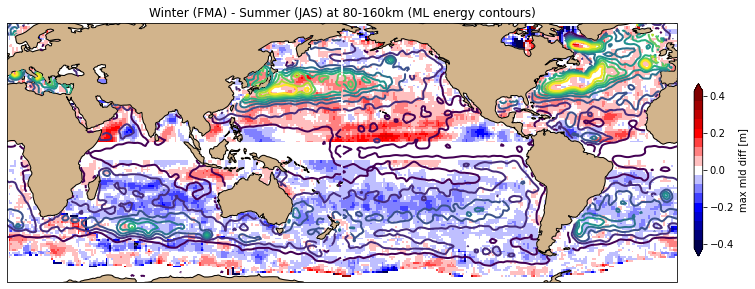

In [117]:
# scale = np.where(coarsening_factors == 10)[0]
# seas = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
# for i in range(np.shape(mean_diff0)[1]):
#     for j in range(np.shape(mean_diff0)[2]):
#         seas[i,j] = (np.nanmax(mean_diff0[:, i, j, scale]) - np.nanmin(mean_diff0[:, i, j, scale])) # /np.nanmean(mean_diff0[:, i, j, scale]))
# seas_xr = xr.DataArray(data=np.transpose(seas), name='seas', dims=['latitude', 'longitude'], coords=data_coords) 
# sea_tp = [0, .1]
cmap_sea = plt.get_cmap('plasma',13)

f, ax = plt.subplots(1,1,figsize=(12,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# axp = seas_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax,transform=ccrs.PlateCarree(), \
#                                                              vmin=sea_tp[0], vmax=sea_tp[1], \
#                                                              cmap=cmap_sea, zorder=0, add_colorbar=False)
# axp = seas_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax,transform=ccrs.PlateCarree(), \
#                                                              vmin=sea_tp[0], vmax=sea_tp[1], \
#                                                              cmap=cmap_sea, zorder=0, add_colorbar=False)

# -- fractional seasonal change in 80-160 km scales 
# win_m_sum_80_160 = np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0) # lon_bins[1:-1], lat_bins[1:-1]
axp=mfwinsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax,transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)

# -- mld difference * ml density differnce (sylvia's method)
ax.contour(mld_lon,mld_lat,mld_energy_smooth,levels=np.arange(50,260,25),\
            linewidths=2,zorder=2,transform=ccrs.PlateCarree()) # levels=[100,200] colors='r',linewidths=1.5,

r1 = np.where(mld_lon < 0)[0]
mld_test = np.concatenate((mld_energy_smooth[:,r1[-1]+1:], mld_energy_smooth[:,r1]),axis=1)
# ax.contour(lon_bin_c, lat_bin_c, mld_test[20:-20,:]*np.transpose(0.5*mean_sla_total), \
#                  levels=[0.75,5,10,20,30], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
cbpos = [0.92, 0.322, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='max mld diff [m]')
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax.set_title('Winter (FMA) - Summer (JAS) at 80-160km (ML energy contours)')
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_ml_seasonality_r1.jpg', dpi=500)

In [124]:
win_m_sum_80_160 = np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0)
overlap_x,overlap_y = np.where((mld_test[21:-20,0:-1]>60) & (np.abs(win_m_sum_80_160) > 0.05))

In [125]:
test_m = np.zeros(np.shape(win_m_sum_80_160))
for i in range(len(overlap_x)):
    test_m[overlap_x[i],overlap_y[i]] = 1

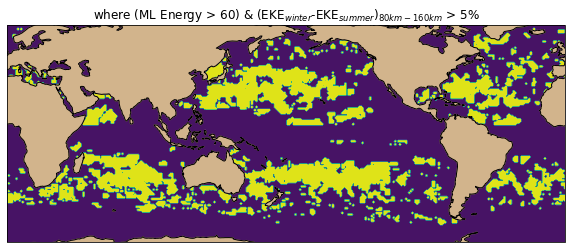

In [140]:
f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
ax.contourf(lon_bins[1:-1],lat_bins[1:-1], test_m,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.set_title(r'where (ML Energy > 60) & (EKE$_{winter}$-EKE$_{summer}$)$_{80km-160km}$ > 5%',fontsize=12)
ax.coastlines()
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_eke_ml_overlap_seasonality_r1.jpg', dpi=500)

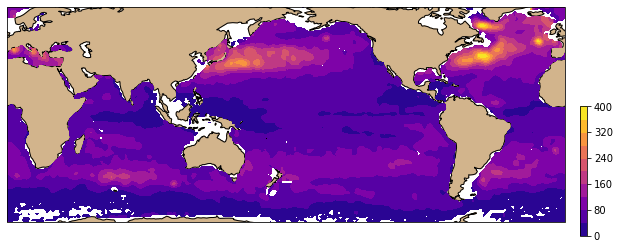

In [141]:
win_m_sum_80_160 = np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0)
overlap = np.where((mld_test[21:-20,0:-1]>50) & (win_m_sum_80_160 > 0.01))[0]

data_coords = {'latitude': mld_lat, 'longitude': mld_lon}
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
arg_mld = xr.DataArray(data=mld_test[20:-20,:]*np.transpose(0.2*mean_sla_total), \
                       dims=['latitude', 'longitude'], coords=data_coords)
tcmap_2 = plt.get_cmap('jet')

f, ax = plt.subplots(1,1,figsize=(10,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# mld_p = arg_mld.plot(ax=ax,transform=ccrs.PlateCarree(), \
#                      norm=LogNorm(vmin=0.1, vmax=100), \
#                      cmap=tcmap_2, zorder=0, add_colorbar=False)
mld_p=ax.contourf(mld_lon,mld_lat,mld_energy_smooth,levels=np.arange(0,430,40),\
                  cmap=plt.get_cmap('plasma'),zorder=2,transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(mld_p, cax=cax, orientation='vertical', extend='both', label='')
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_argo_ml_seasonal_energy_r1.jpg', dpi=500)

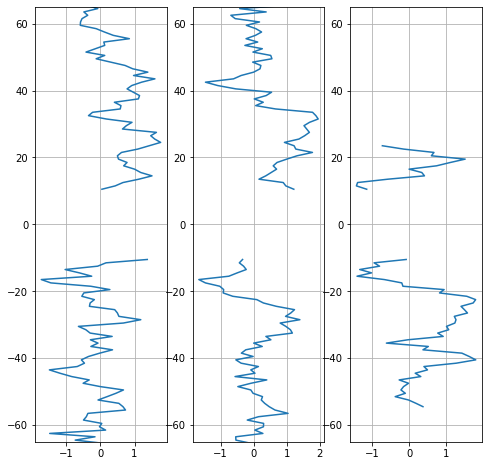

In [241]:
v_in = np.where((lat_bin_c > -10) & (lat_bin_c < 10))[0]
lag_mask_c = mo_lag.copy() # np.nanmean(mo_lag,axis=0)  # meso_frac2.copy() 
lag_mask_c[:, v_in] = np.nan

atl_in = np.where((lon_bins[1:-1] > 280) & (lon_bins[1:-1] < 360))[0]
pac_in = np.where((lon_bins[1:-1] > 120) & (lon_bins[1:-1] < 270))[0]
ind_in = np.where((lon_bins[1:-1] > 50) & (lon_bins[1:-1] < 120))[0]
ind_in2 = np.where((lat_bins[1:-1] > -55) & (lat_bins[1:-1] < 25))[0]

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,8))
# ax.plot(lag_mask_c, lat_bin_c)

ax1.plot(np.nanmean(lag_mask_c[atl_in, :], axis=0), lat_bin_c, label='Atl.')
ax2.plot(np.nanmean(lag_mask_c[pac_in, :], axis=0), lat_bin_c, label='Pac.')
ax3.plot(np.nanmean(lag_mask_c[ind_in][:, ind_in2], axis=0), lat_bin_c[ind_in2], label='Ind.')
ax1.set_ylim([-65,65])
ax2.set_ylim([-65,65])
ax3.set_ylim([-65,65])
ax1.grid()
ax2.grid()
ax3.grid()

# ax.scatter(np.nanmean(mean_sla0, axis=0).flatten(), mo_lag.flatten())
# ax.set_xscale('log')

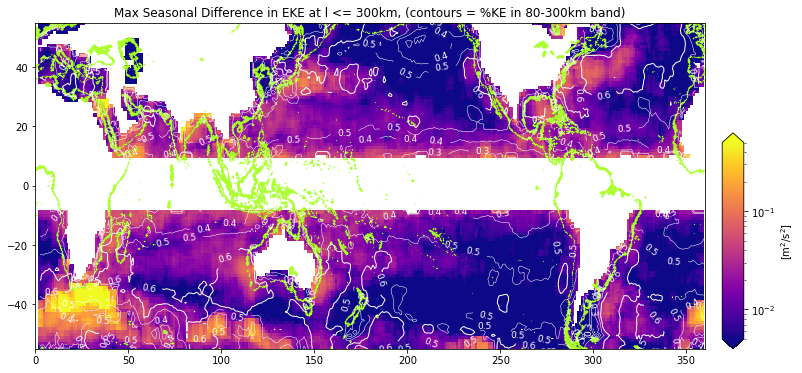

In [101]:
# locations where seasonality at the mesoscale is significant 
scale1 = np.where(coarsening_factors == 15)[0]
scale2 = np.where(coarsening_factors == 12)[0]
pct_diff_cutoff = 0.1
# find month that has most eke at each scale 
meso_season = np.nan*np.ones(np.shape(mean_diff0[0, :, :, 0]))
# max_month_2 = np.nan * np.ones(np.shape(mean_diff0[0, :, :, 0]))
for i in range(np.shape(mean_diff0)[1]):        # lat
    for j in range(np.shape(mean_diff0)[2]):    # lon 
        # -- scale1 (smaller)
        if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale1]))) & \
        (np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1]))/np.nanmean(mean_diff0[:, i, j, scale1]) > pct_diff_cutoff):
            this_ij = np.where(mean_diff0[:, i, j, scale1] == np.nanmax(mean_diff0[:, i, j, scale1]))[0]
            if len(this_ij) > 1:
                meso_season[i, j] = np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1])) # /np.nanmean(mean_sla0[:, i, j])
            else:
                meso_season[i, j] = np.abs(np.nanmax(mean_diff0[:, i, j, scale1]) - np.nanmin(mean_diff0[:, i, j, scale1])) # /np.nanmean(mean_diff0[:, i, j])
        # -- scale2 (larger) 
        # if (~np.isnan(np.nanmax(mean_diff0[:, i, j, scale2]))) & \
        # (np.abs(np.nanmax(mean_diff0[:, i, j, scale2]) - np.nanmin(mean_diff0[:, i, j, scale2]))/np.nanmean(mean_diff0[:, i, j, scale2]) > pct_diff_cutoff):
        #     test = mean_diff0[:, i, j, scale2] - mean_diff0[:, i, j, scale1]  # difference between scales 
        #     this_ij = np.where(test == np.nanmax(test))[0]
        #     # this_ij = np.where(mean_diff0_11[:, i, j] == np.nanmax(mean_diff0_11[:, i, j]))[0]
        #     if len(this_ij) > 1:
        #         max_month_2[i, j] = np.nanmean(this_ij) + 1
        #     else:
        #         max_month_2[i, j] = this_ij + 1
        
v_in = np.where((lat_bin_c > -9) & (lat_bin_c < 9))[0]
mean_ms_mask = meso_season.copy() 
mean_ms_mask[:, v_in] = np.nan
        
f, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(x4['lon'].values, x4['lat'].values, color=border_col, zorder=1, s=0.01)
axp = ax.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_ms_mask), \
                norm=LogNorm(vmin=0.005, vmax=.5), zorder=0, cmap=plt.get_cmap('plasma'))
                # vmin=0, vmax=.15, zorder=0, cmap=plt.get_cmap('plasma'))
dr = ax.contour(lon_bin_c[1:], lat_bin_c[1:], np.transpose(mean_mf_mask), \
           levels=[0.2, 0.3, 0.4, 0.5], linewidths=0.5, colors='w')
ax.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')
dr2 = ax.contour(lon_bin_c[1:], lat_bin_c[1:], np.transpose(mean_mf_mask), \
           levels=[0.6], linewidths=1, colors='w')
ax.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')
ax.clabel(dr2, fontsize=9, inline=1, fmt = '%1.1f')
cbpos = [0.92, 0.125, 0.025, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label=r'[m$^2$/s$^2$]')
# ax.set_title(r'% KE between ' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + \
#              '-' + str(np.int(coarsening_factors[scale2][0]*hor_grid_spacing)) + 'km')
ax.set_title(r'Max Seasonal Difference in EKE at l <= ' + \
             str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + 'km, (contours = %KE in 80-300km band)')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s + 5, lat_n - 5])
plt.show()
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/' + this_sat + '_seasonal_differnces.jpg', dpi=500)


In [140]:
# length scale at which normalized bands are maxima    
mi = np.where((band_centers > 80) & (band_centers < 250))[0]
mi_band = band_centers[mi]

# find scale that has most eke at each location 
loc_var_a = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c), len(band_centers)))
band_var_a = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c), len(band_centers)-1))
max_scale = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in range(len(lon_bin_c)):
    for j in range(len(lat_bin_c)):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]        
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2       
        ll = np.where((lat_bin_c > (this_lat0 - 0.25)) & (lat_bin_c < (this_lat1 + 0.25)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0.25)) & (lon_bin_c < (this_lon1 + 0.25)))[0]
        
        # mke for all filter scales at all locations (flip so we go from large scale to small scale)
        loc_var_a[i, j, :] = np.nanmean(mean_sla_smooth[:][:, kk, ll, :], axis=0)
            # [np.nanmean(mean_sla_smooth0[:][:, kk, :][:, :, ll]), np.nanmean(mean_sla_smooth26[:][:, kk, :][:, :, ll])]  # mean_diff0_3
        band_var_a[i, j, :] = (loc_var_a[i, j, 1:] - loc_var_a[i, j, 0:-1])/(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))


        # -- max scale
        
        this_ij = np.where(band_var_a[i, j, mi] == np.nanmax(band_var_a[i, j, mi]))[0]
        if (len(this_ij) >= 1) & (len(this_ij) <= 3):
            max_scale[i, j] = mi_band[this_ij]
            # if len(this_ij) > 1:
            #     max_scale[i, j] = np.nanmean(this_ij) + 1
            # else:
            #     max_month_1[i, j] = this_ij + 1
                

In [138]:
np.nanmin(max_scale)

85.0

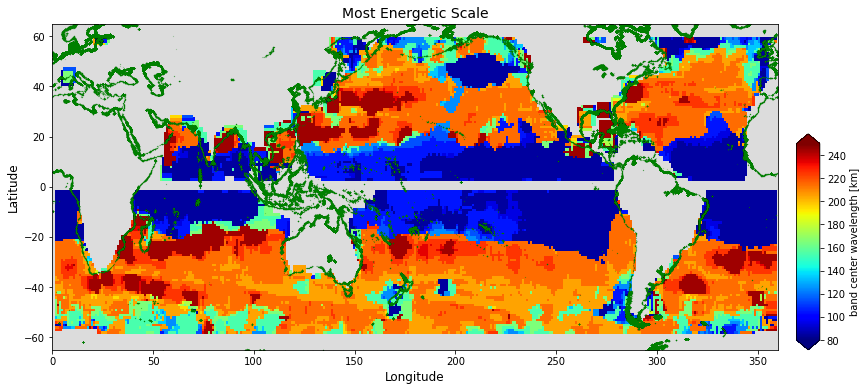

In [145]:
f, ax1 = plt.subplots(1,1,figsize=(13,6))
ax1.set_facecolor('#DCDCDC')
ax1.scatter(x4['lon'].values, x4['lat'].values, color='g', zorder=1, s=0.01)
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(max_scale), \
                 vmin=80, vmax=250, zorder=0, cmap=plt.get_cmap('jet'))  # plt.get_cmap('twilight')# cmocean.cm.phase)
# dr = ax1.contour(lon_bin_c, lat_bin_c, def_rad, levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2)
# ax1.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')
cbpos2 = [0.92, 0.125, 0.025, 0.5]
cax2 = f.add_axes(cbpos2)
cb2 = f.colorbar(axp, cax=cax2, orientation='vertical', extend='both', label='band center wavelength [km]')
ax1.set_xlim([lon_w, lon_e])
ax1.set_ylim([lat_s, lat_n])
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.set_title('Most Energetic Scale', fontsize=14)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/' + this_sat + '_most_energetic.jpg', dpi=500)

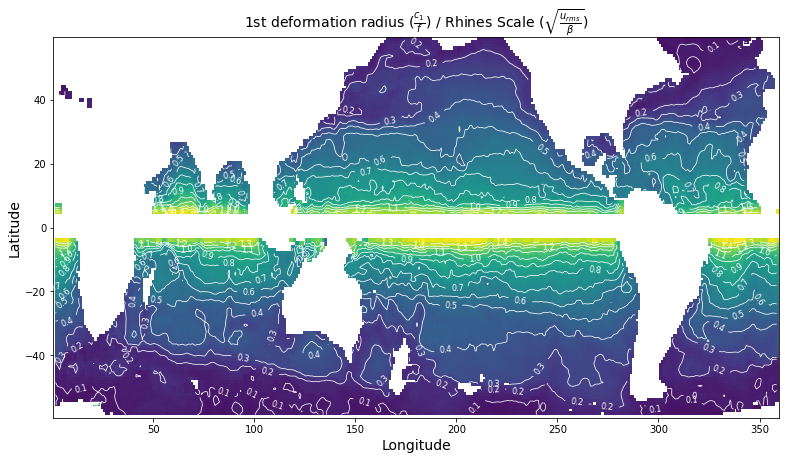

In [175]:
f, ax = plt.subplots(1,1,figsize=(13,7))
ax.pcolor(lon_bin_c, lat_bin_c, def_rad/(rhines/1000), vmin=0, vmax=1.5)
dr = ax.contour(lon_bin_c, lat_bin_c, def_rad/(rhines/1000), levels=np.arange(0, 10, 0.1), colors='w', linewidths=0.75, zorder=2)
ax.clabel(dr, fontsize=8, inline=1, fmt = '%1.1f')
ax.set_xlabel('Longitude',fontsize=14)
ax.set_ylabel('Latitude',fontsize=14)
ax.set_title(r'1st deformation radius ($\frac{c_1}{f}$) / Rhines Scale ($\sqrt{\frac{u_{rms}}{\beta}}$)', fontsize=14)
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/ld1_to_rhines.jpg', dpi=500)

In [ ]:
# old 
# if we filter by Ld1, now make a global map 
mean_eke_leq_Ld1 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):       
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]     
        this_lon0 = this_lon - lon_win/2
        this_lon1 = this_lon + lon_win/2
        this_lat0 = this_lat - lat_win/2
        this_lat1 = this_lat + lat_win/2      
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & \
                            (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1) & \
                            (np.abs(lat_record[ai[tib]]) > 5))[0]
            if count < 1:
                vel_ld1_i = vel_filtered_Ld[ai[tib]][:, inn2].flatten()
                sla_total_i = sla[ai[tib]][:, inn2].flatten()
                count = count + 1
            else:
                vel_ld1_i = np.append(vel_ld1_i, vel_filtered_Ld[ai[tib]][:, inn2].flatten())
                sla_total_i = np.append(sla_total_i, sla[ai[tib]][:, inn2].flatten())
        if (len(ai) > 1):
            if (len(vel_ld1_i) > thresh):
                mean_eke_leq_Ld1[i, j] = np.nanmean(sla_total_i**2 -vel_ld1_i**2)              
        ai = 0

In [ ]:
# check sample box and paths that fall within (and look at local scattering of eke vs. KE)
this_lon0 = 298
this_lon1 = 300
this_lon0 = 210
this_lon1 = 212
this_lat0 = 36
this_lat1 = 38
inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
[ci, ai, bi] = np.intersect1d(track_record, np.unique(track_t[inn]), return_indices=True)

fi_1 = 6
fi_2 = 4
count = 0
count2 = 0
f, ax = plt.subplots(1,1,figsize=(7,4))
for tib in range(len(ai)):
    inn2 = np.where((lon_record[ai[tib]] > this_lon0) & (lon_record[ai[tib]] < this_lon1) & (lat_record[ai[tib]] > this_lat0) & (lat_record[ai[tib]] < this_lat1))[0]
    if count < 1:
        sla_i = sla[ai[tib]][:, inn2].flatten()
        sla_smooth_100_i = sla_s_dict[fi_1][ai[tib]][:, inn2].flatten() 
        sla_sq_smooth_100_i = sla_sq_s_dict[fi_1][ai[tib]][:, inn2].flatten() 
        sla_smooth_101_i = sla_s_dict[fi_2][ai[tib]][:, inn2].flatten() 
        sla_sq_smooth_101_i = sla_sq_s_dict[fi_2][ai[tib]][:, inn2].flatten() 
        count = count + 1
    else:
        sla_i = np.append(sla_i, sla[ai[tib]][:, inn2].flatten())
        sla_smooth_100_i = np.append(sla_smooth_100_i, sla_s_dict[fi_1][ai[tib]][:, inn2].flatten())
        sla_sq_smooth_100_i = np.append(sla_sq_smooth_100_i, sla_sq_s_dict[fi_1][ai[tib]][:, inn2].flatten())
        sla_smooth_101_i = np.append(sla_smooth_101_i, sla_s_dict[fi_2][ai[tib]][:, inn2].flatten())
        sla_sq_smooth_101_i = np.append(sla_sq_smooth_101_i, sla_sq_s_dict[fi_2][ai[tib]][:, inn2].flatten())
    
    if count2 < 1:
        ke_check = sla_i**2
        eke_check_100 = sla_sq_smooth_100_i - sla_smooth_100_i**2
        eke_check_101 = sla_sq_smooth_101_i - sla_smooth_101_i**2
        eke_mke_100 = (sla_sq_smooth_100_i - sla_smooth_100_i**2)/(sla_smooth_100_i**2)
        eke_mke_101 = (sla_sq_smooth_101_i - sla_smooth_101_i**2)/(sla_smooth_101_i**2)
        count2 = 1
    else:
        ke_check = np.concatenate((ke_check, sla_i**2))
        eke_check_100 = np.concatenate((eke_check_100, (sla_sq_smooth_100_i - sla_smooth_100_i**2)))
        eke_check_101 = np.concatenate((eke_check_101, (sla_sq_smooth_101_i - sla_smooth_101_i**2)))
        eke_mke_100 = np.concatenate((eke_mke_100, (sla_sq_smooth_100_i - sla_smooth_100_i**2)/(sla_smooth_100_i**2)))
        eke_mke_101 = np.concatenate((eke_mke_101, (sla_sq_smooth_101_i - sla_smooth_101_i**2)/(sla_smooth_101_i**2)))
    ax.scatter(lon_record[ai[tib]], lat_record[ai[tib]], s=0.1)
    
ax.plot([this_lon0, this_lon1],[this_lat0, this_lat0], color='k', linewidth=0.5)
ax.plot([this_lon0, this_lon1],[this_lat1, this_lat1], color='k', linewidth=0.5)
ax.set_xlim([100, lon_e])
ax.set_ylim([0, 50])
plt.show()